In [35]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [69]:
# Let's make a dataset handling object to make our data more accessible as we complete our task.
class Dataset_Handler():
    def __init__(self, sequence, lidar=False):
        
        # Tells odometry function if handler contains lidar info
        self.lidar = lidar
        
        # Sets file paths and defines ground truth poses
        # self.seq_dir = './dataset/sequences/{}/'.format(sequence)
        self.seq_dir = './large_data/stereo_processed/'
        # self.poses_dir = './dataset/poses/{}.txt'.format(sequence)
        # poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get name of files to iterate through
        self.left_image_files = sorted(os.listdir(self.seq_dir + 'left'))
        self.right_image_files = sorted(os.listdir(self.seq_dir + 'right'))
#         self.velodyne_files = sorted(os.listdir(self.seq_dir + 'velodyne'))
        self.num_frames = len(self.left_image_files)
        # self.lidar_path = self.seq_dir + 'velodyne/'
        
        # Get calibration settings from scene
        # P0 and P1 are grayscale. P2 and P3 are RGB
        # calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        f, px, py = 983.044006, 643.646973, 493.378998
        K_right = np.array([
                    [f, 0, px],
                    [0, f, py],
                    [0, 0, 1]
                    ])
        ext_right = np.array([0.000000, -0.000000, 1.000000, 0.000000,
                            1.000000, 0.000000, -0.000000, 0.239983,
                            0.000000, 1.000000, 0.000000, 0.000000]).reshape((3,4))
        ext_right[:3,:3] = np.eye(3)
        self.P1 = K_right @ ext_right
        f, px, py = 983.044006, 643.646973, 493.378998
        K_left = np.array([
                    [f, 0, px],
                    [0, f, py],
                    [0, 0, 1]
                    ])
        ext_left = np.array([0.000000, -0.000000, 1.000000, 0.000000,
                            1.000000, 0.000000, -0.000000, 0.0,
                            0.000000, 1.000000, 0.000000, 0.000000]).reshape((3,4))
        ext_left[:3,:3] = np.eye(3)
        self.P0 = K_left @ ext_left
        # self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        # self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        # self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        # self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        
        # Tranformation matrix for lidar
        # self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        # self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
        #                                   delimiter=' ', 
        #                                   header=None))
        # self.gt = np.zeros((len(poses), 3, 4))
        # for i in range(len(poses)):
        #     self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        # Will use generators to provide data sequentially to save RAM
        self.reset_frames()
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.seq_dir + 'left/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'right/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'left/' 
                                           + self.left_image_files[1], 0)
        # if self.lidar:
        #     self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
        #                                         dtype=np.float32, 
        #                                         count=-1).reshape((-1, 4))
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'left/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'right/' + name_right, 0)
                            for name_right in self.right_image_files)
        # if self.lidar:
        #     self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
        #                                     dtype=np.float32, 
        #                                     count=-1).reshape((-1, 4))
        #                         for velodyne_file in self.velodyne_files)
        pass

In [70]:
handler = Dataset_Handler('00')
print(handler.P0, handler.P1)

[[983.044006   0.       643.646973   0.      ]
 [  0.       983.044006 493.378998   0.      ]
 [  0.         0.         1.         0.      ]] [[983.044006     0.         643.646973     0.        ]
 [  0.         983.044006   493.378998   235.91384969]
 [  0.           0.           1.           0.        ]]


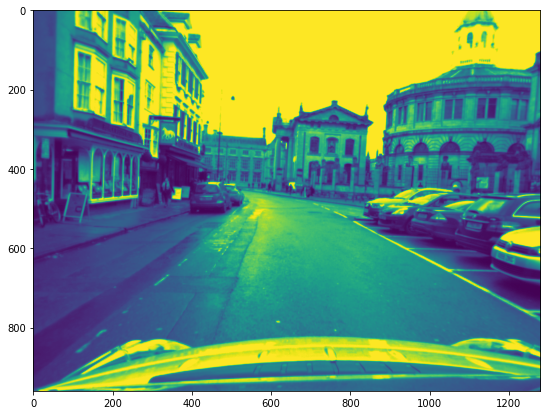

In [71]:
# This is the first left image
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

In [72]:
print(f"The first left image has shape {handler.first_image_left.shape}")

The first left image has shape (960, 1280)


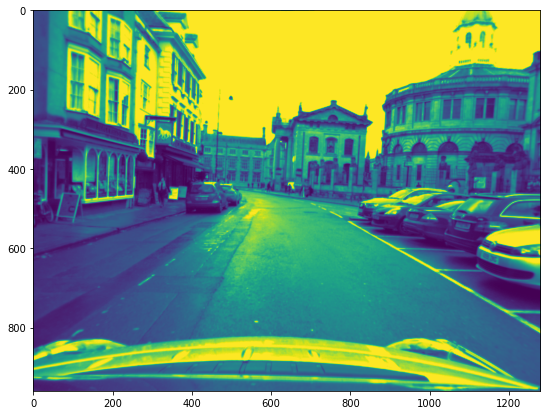

In [73]:
# This is the first right image
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_right);

In [74]:
print(f"Similarly, the first right image has shape {handler.first_image_right.shape}")

Similarly, the first right image has shape (960, 1280)


In [75]:
# Let's compute the disparities between the left and right images
# Notes: StereoBM is faster, but StereoSGBM produces better results
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 1 * block_size ** 2,
                                        P2 = 32 * 1 * block_size ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    return disp_left

Time to compute disparity map using StereoBM 0:00:00.048839


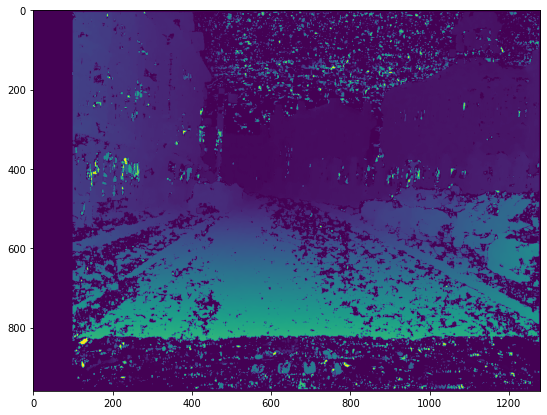

In [76]:
disp = compute_left_disparity_map(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM 0:00:00.135212


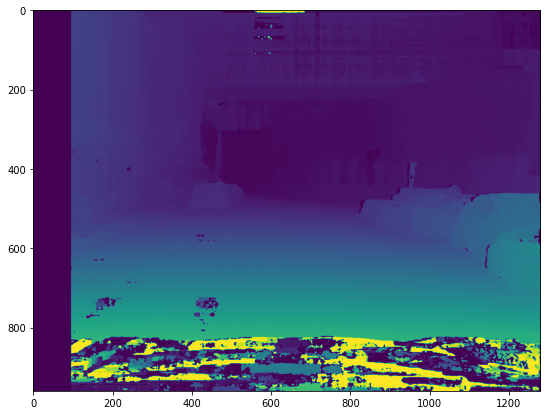

In [77]:
disp = compute_left_disparity_map(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [78]:
# We can see that StereoSGBM takes around 3x as long, but produces a much more contiguous
# disparity map, with less gaps in information

In [79]:
# We can see that there is a gap of the left side of the image where the right camera did not have 
# matching information. This means that we should apply a mask when looking for features to match 
# from one frame to the next so that we can use features which fall in the area of the picture for 
# which we have depth information.

In [46]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [47]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    if rectified:
        b = t_right[0] - t_left[0]
    else:
        b = t_left[0] - t_right[0]
        
    f = k_left[0][0]
    
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [48]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

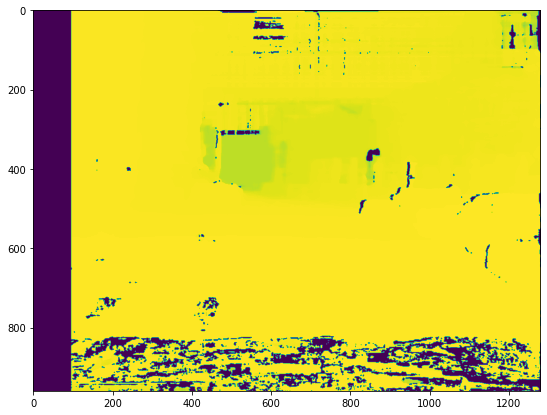

In [49]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.grid(False)
plt.imshow(depth);

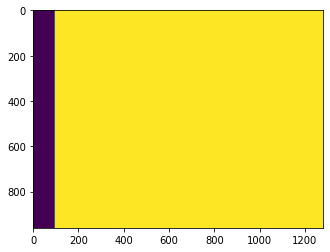

In [51]:
# We can constuct a mask using this information like so
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0]
xmax = depth.shape[1]
cv2.rectangle(mask, (96, 0), (xmax, ymax), (255), thickness=-1)
plt.imshow(mask);

In [52]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False,
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left,
                                      img_right,
                                      matcher=matcher,
                                      rgb=rgb,
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoSGBM 0:00:00.141621


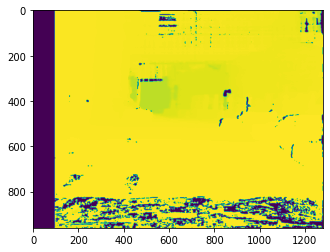

In [53]:
depth = stereo_2_depth(handler.first_image_left,
                       handler.first_image_right,
                       handler.P0,
                       handler.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

In [44]:
handler.first_pointcloud.shape

AttributeError: 'Dataset_Handler' object has no attribute 'first_pointcloud'

In [45]:
pcloud = handler.first_pointcloud
print('full pcloud shape', pcloud.shape)
trimmed_pcloud = pcloud[pcloud[:, 0] > 0]
print('trimmed pcloud shape', trimmed_pcloud.shape)

AttributeError: 'Dataset_Handler' object has no attribute 'first_pointcloud'

In [20]:
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler.Tr.dot(trimmed_pcloud.T)
#cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler.P0.dot(cam_xyz)
projection /= projection[2]
projection[:, :5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [21]:
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler.Tr.dot(trimmed_pcloud.T)
cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler.P0.dot(cam_xyz)
projection[:, :5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [22]:
pixel_coords = np.round(projection, 0).T.astype('int')
pixel_coords[:5]

array([[607, 153,   1],
       [605, 153,   1],
       [602, 153,   1],
       [594, 154,   1],
       [592, 154,   1]])

In [23]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
        
    return render

In [24]:
render = pointcloud2image(handler.first_pointcloud, 
                          handler.imheight,
                          handler.imwidth,
                          handler.Tr,
                          handler.P0
                         )

In [25]:
render.shape

(376, 1241)

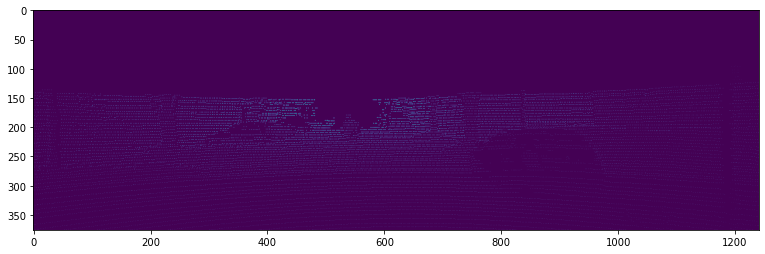

In [26]:
plt.figure(figsize=(13,5))
plt.imshow(render)

In [27]:
pcloud_frames = (pointcloud2image(next(handler.pointclouds),
                                  handler.imheight,
                                  handler.imwidth,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

#poses = (gt for gt in handler.gt)

In [28]:
%matplotlib tk

In [29]:
handler.reset_frames()
poses = (gt for gt in handler.gt)

In [30]:
xs = []
ys = []
zs = []
compute_times = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-20, azim=270)
ax.plot(handler.gt[:, 0, 3], handler.gt[:, 1, 3], handler.gt[:, 2, 3], c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

stereo_l = handler.images_left
stereo_r = handler.images_right

for i in range(handler.num_frames // 50):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    start = datetime.datetime.now()
    disp = compute_left_disparity_map(img_l, img_r, matcher='sgbm')
    disp /= disp.max()
    #disp = 1 - disp
    disp = (disp*255).astype('uint8')
    #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = next(pcloud_frames)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    
    gt = next(poses)
    xs.append(gt[0, 3])
    ys.append(gt[1, 3])
    zs.append(gt[2, 3])
    plt.plot(xs, ys, zs, c='chartreuse')
    plt.pause(0.000000000000000001)
    cv2.imshow('camera', img_l)
    cv2.imshow('disparity', disp)
    cv2.imshow('lidar', pcloud)
    cv2.waitKey(1)
    
    end = datetime.datetime.now()
    compute_times.append(end-start)
    
plt.close()
cv2.destroyAllWindows()

In [31]:
plt.close()

In [54]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [55]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [56]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [57]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [58]:
%matplotlib inline

Time to compute disparity map using StereoSGBM 0:00:00.128691
Number of matches before filtering: 3389
Number of matches after filtering: 1331


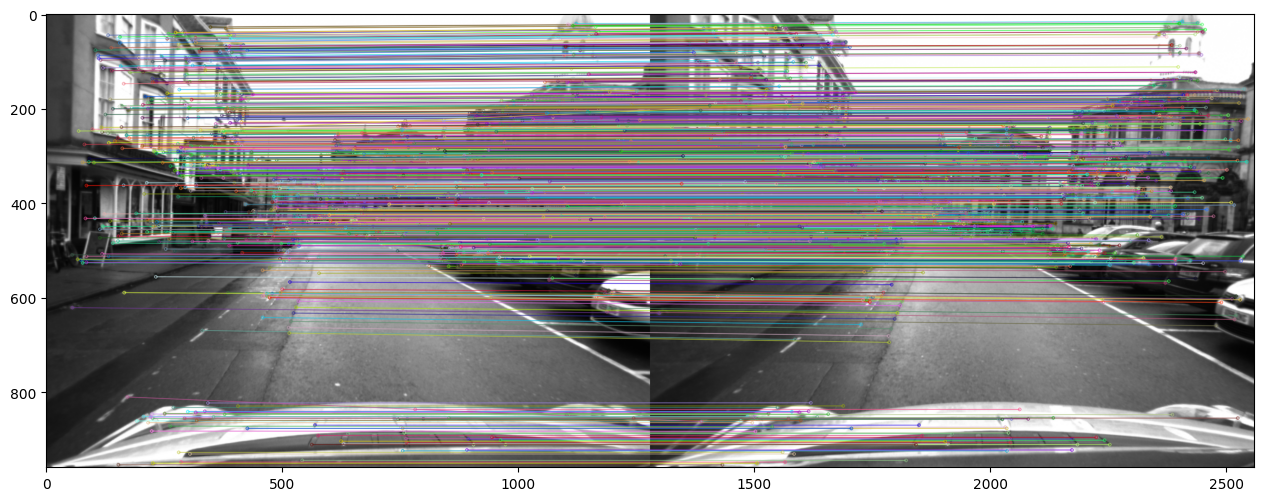

In [59]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM 0:00:00.045880
Number of matches before filtering: 3389
Number of matches after filtering: 1331


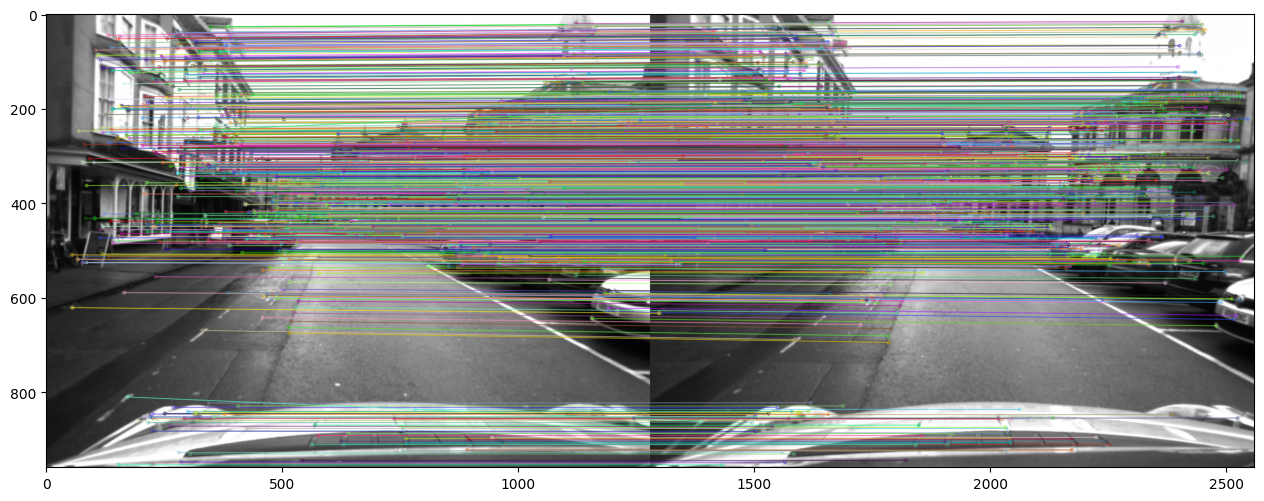

In [60]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Number of matches before filtering:  500
Number of matches after filtering:  43
Time to match and filter:  0:00:00.070811


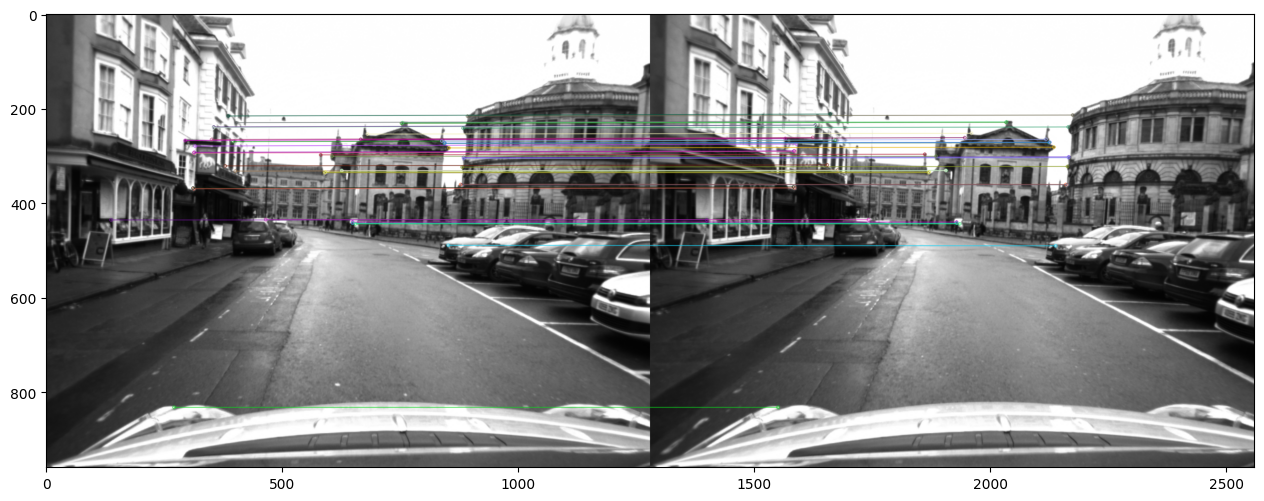

In [61]:
# Using the orb features/descriptors
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
start = datetime.datetime.now()
kp0, des0 = extract_features(image_left, 'orb', mask)
kp1, des1 = extract_features(image_plus1, 'orb', mask)
matches = match_features(des0, des1, matching='BF', detector='orb', sort=False)
print('Number of matches before filtering: ', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering: ', len(matches))
end = datetime.datetime.now()
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [62]:
def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    
    object_points = np.zeros((0, 3))
    delete = []
    
    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(round(v)), int(round(u))]
        
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z * (u - cx) / fx
        y = z * (v - cy) / fy
        object_points = np.vstack([object_points, np.array([x, y, z])])
        #object_points = np.vstack([obeject_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])
        
    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

In [63]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)
k

array([[983.044006,   0.      , 643.646973],
       [  0.      , 983.044006, 493.378998],
       [  0.      ,   0.      ,   1.      ]])

In [64]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth)
print("Rotation Matrix:")
print(rmat.round(4))
print("Translation Vector:")
print(tvec.round(4))

Rotation Matrix:
[[-0.9979 -0.0082 -0.0645]
 [ 0.0085 -1.     -0.0037]
 [-0.0645 -0.0042  0.9979]]
Translation Vector:
[[ -4.3942]
 [ -2.1652]
 [155.0564]]


In [65]:
transformation_matrix = np.hstack([rmat, tvec])
print(transformation_matrix.round(4))

[[-9.979000e-01 -8.200000e-03 -6.450000e-02 -4.394200e+00]
 [ 8.500000e-03 -1.000000e+00 -3.700000e-03 -2.165200e+00]
 [-6.450000e-02 -4.200000e-03  9.979000e-01  1.550564e+02]]


In [66]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None,
                    stereo_matcher='sgbm', mask=None, subset=None, plot=False):
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector),
                                                                  matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
        
#     if plot:
#         fig = plt.figure(figsize=(14, 14))
#         ax = fig.add_subplot(projection='3d')
#         ax.view_init(elev=-20, azim=270)
#         xs = handler.gt[:, 0, 3]
#         ys = handler.gt[:, 1, 3]
#         zs = handler.gt[:, 2, 3]
#         ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
#         ax.plot(xs, ys, zs, c='k')
        
    # Establish a homogeneous transformation matrix. First pose is identity
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
#     if handler.low_memory:
    handler.reset_frames()
    image_plus1 = next(handler.images_left)
        
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
#         if handler.low_memory:
        image_left = image_plus1
        image_plus1 = next(handler.images_left)
        image_right = next(handler.images_right)
#         else:
#             image_left = handler.images_left[i]
#             image_plus1 = handler.images_left[i+1]
#             image_right = handler.images_right[i]
            
        depth = stereo_2_depth(image_left,
                               image_right,
                               P0=handler.P0,
                               P1=handler.P1,
                               matcher=stereo_matcher
                              )
        
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            
            lidar_depth = pointcloud2image(pointcloud,
                                           imheight=imheight,
                                           imwidth=imwidth,
                                           Tr=handler.Tr,
                                           P0=handler.P0
                                          )
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in two subsequent frames
        matches_unfilt = match_features(des0, 
                                        des1,
                                        matching=matching,
                                        detector=detector
                                       )
        #print('Number of features before filtering: ', len(matches_unfilt))
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        
        #print('Number of features after filtering: ', len(matches))
        #print('Length of kp0:', len(kp0))
        #print('Length of kp1:', len(kp1))
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches,
                                                               kp0,
                                                               kp1,
                                                               k_left,
                                                               depth
                                                              )
        
        # Create a blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:
        plt.close()
        
    return trajectory

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.3*distance
Time to compute frame 1: 0:00:00.865700


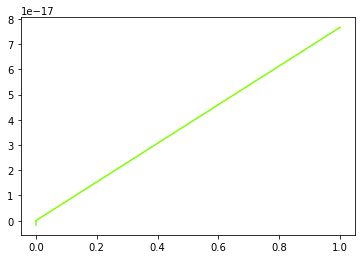

Time to compute frame 2: 0:00:00.844289


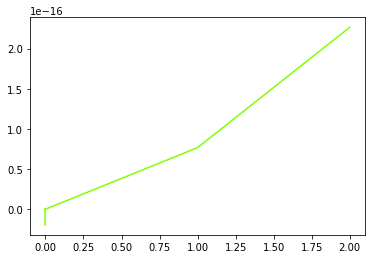

Time to compute frame 3: 0:00:00.859675


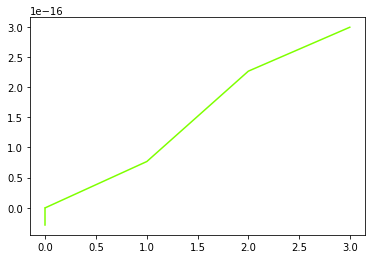

Time to compute frame 4: 0:00:00.882717


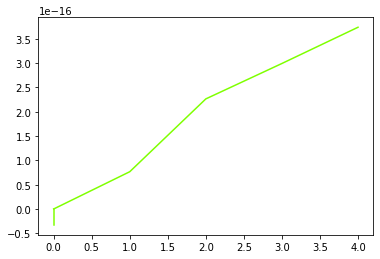

Time to compute frame 5: 0:00:01.001868


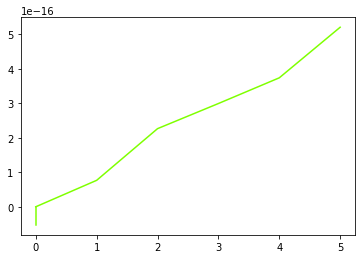

Time to compute frame 6: 0:00:00.860759


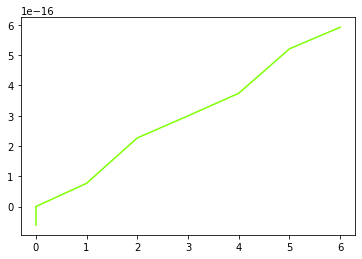

Time to compute frame 7: 0:00:00.900525


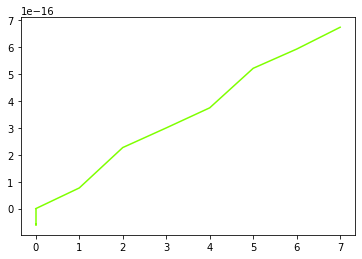

Time to compute frame 8: 0:00:00.878709


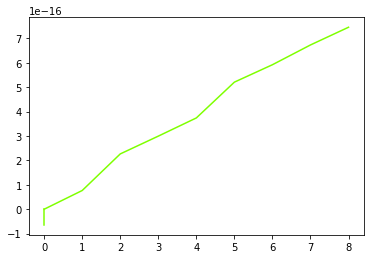

Time to compute frame 9: 0:00:00.836355


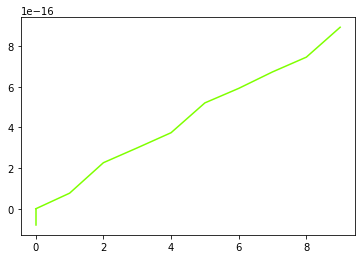

Time to compute frame 10: 0:00:00.853461


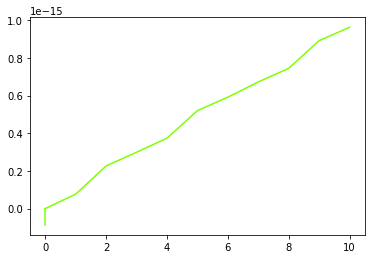

Time to compute frame 11: 0:00:00.973376


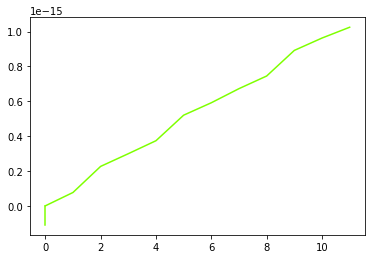

Time to compute frame 12: 0:00:00.876685


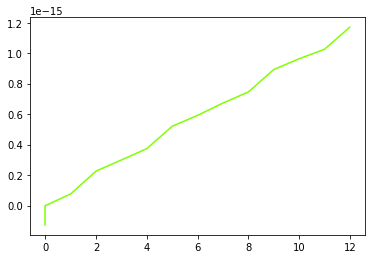

Time to compute frame 13: 0:00:00.836299


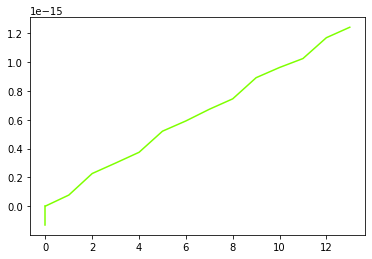

Time to compute frame 14: 0:00:00.854947


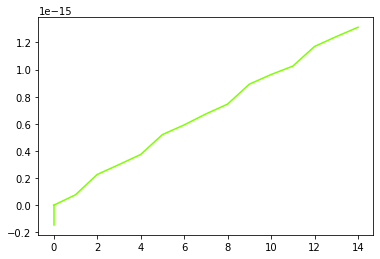

Time to compute frame 15: 0:00:00.986892


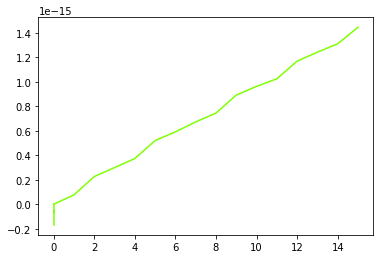

Time to compute frame 16: 0:00:00.907487


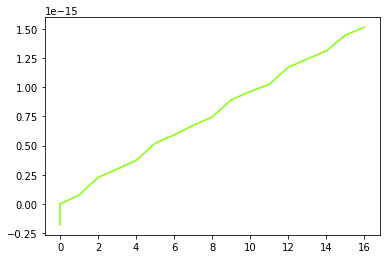

Time to compute frame 17: 0:00:00.841464


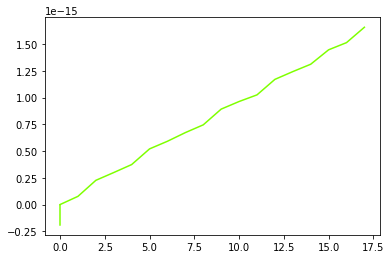

Time to compute frame 18: 0:00:00.970739


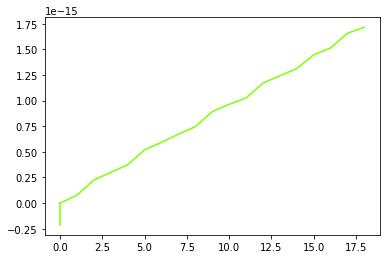

Time to compute frame 19: 0:00:00.889580


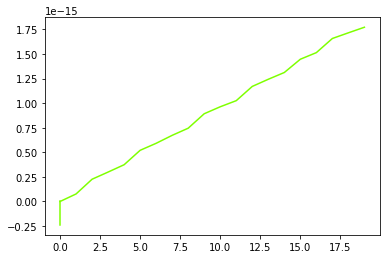

Time to compute frame 20: 0:00:00.855964


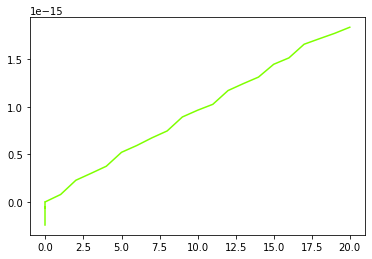

Time to compute frame 21: 0:00:01.026376


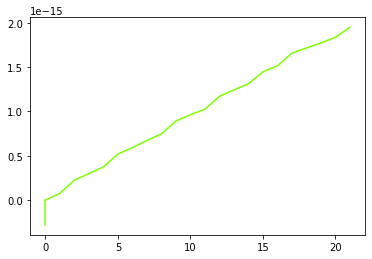

Time to compute frame 22: 0:00:00.953892


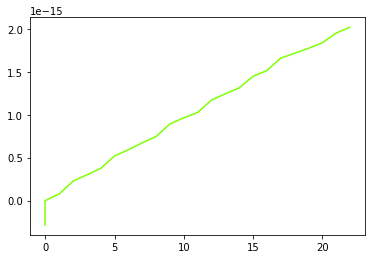

Time to compute frame 23: 0:00:00.983704


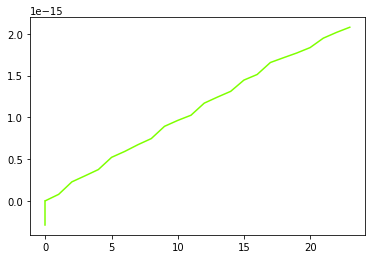

Time to compute frame 24: 0:00:00.963816


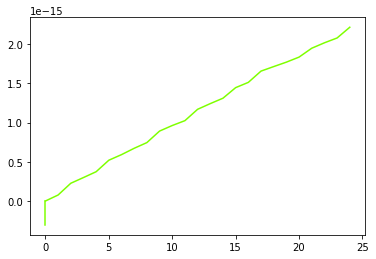

Time to compute frame 25: 0:00:00.942624


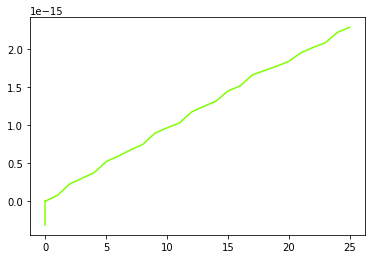

Time to compute frame 26: 0:00:01.023735


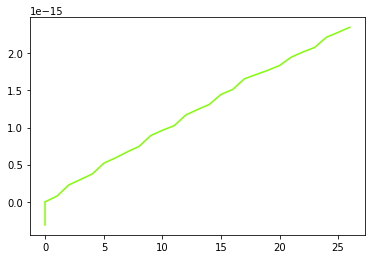

Time to compute frame 27: 0:00:00.952357


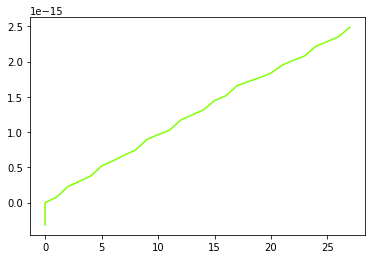

Time to compute frame 28: 0:00:01.251760


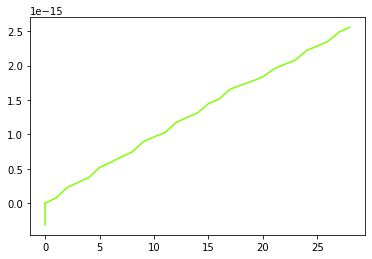

Time to compute frame 29: 0:00:00.925702


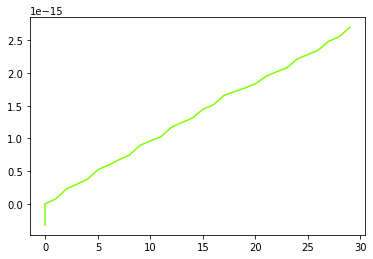

Time to compute frame 30: 0:00:00.895102


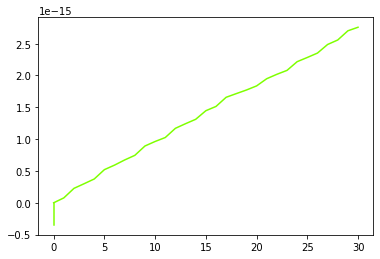

Time to compute frame 31: 0:00:00.885794


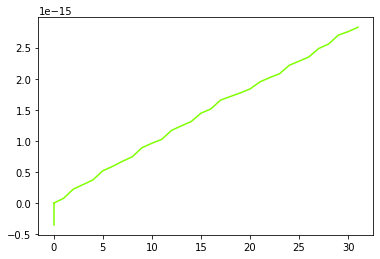

Time to compute frame 32: 0:00:00.887712


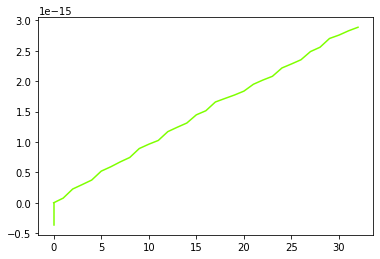

Time to compute frame 33: 0:00:01.057979


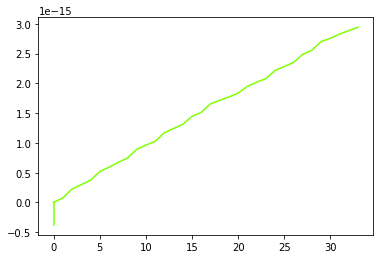

Time to compute frame 34: 0:00:01.078672


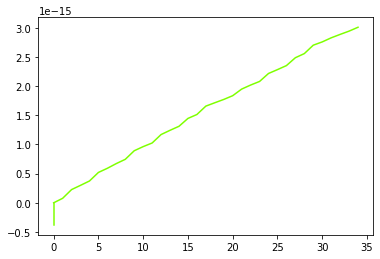

Time to compute frame 35: 0:00:00.962520


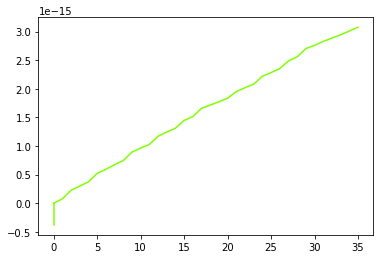

Time to compute frame 36: 0:00:00.890158


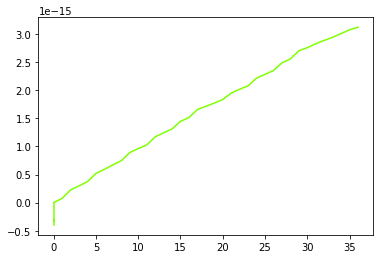

Time to compute frame 37: 0:00:00.903886


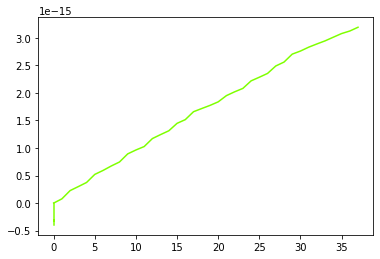

Time to compute frame 38: 0:00:00.984300


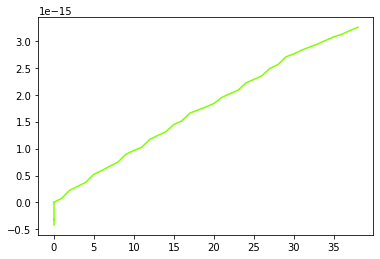

Time to compute frame 39: 0:00:00.941841


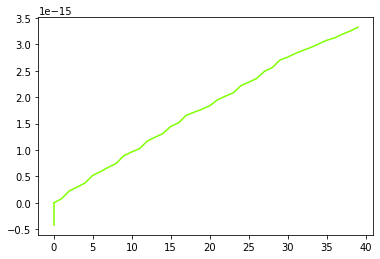

Time to compute frame 40: 0:00:00.989028


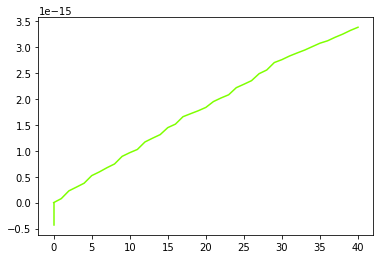

Time to compute frame 41: 0:00:00.930195


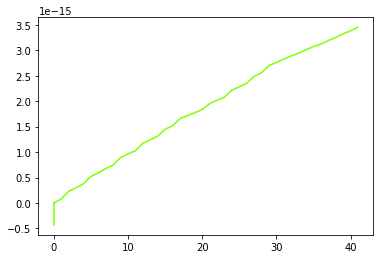

Time to compute frame 42: 0:00:00.960634


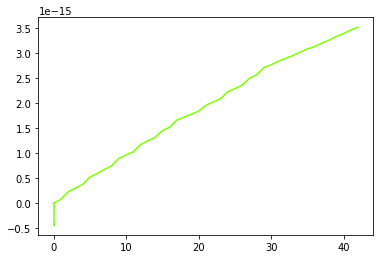

Time to compute frame 43: 0:00:00.973855


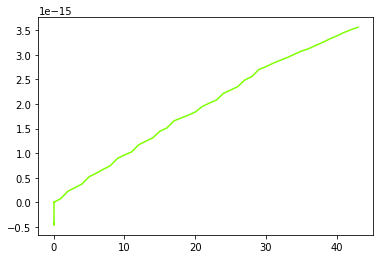

Time to compute frame 44: 0:00:00.982526


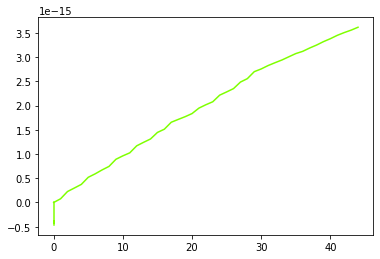

Time to compute frame 45: 0:00:01.117570


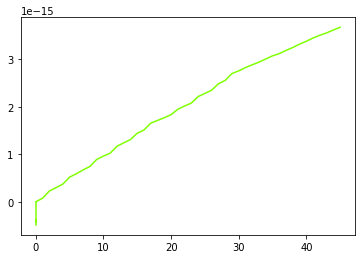

Time to compute frame 46: 0:00:00.890615


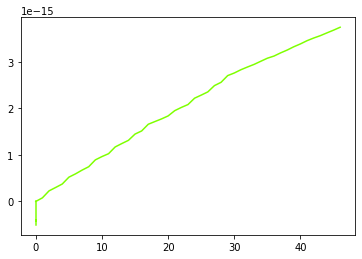

Time to compute frame 47: 0:00:00.908339


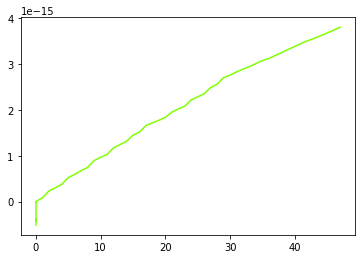

Time to compute frame 48: 0:00:00.914643


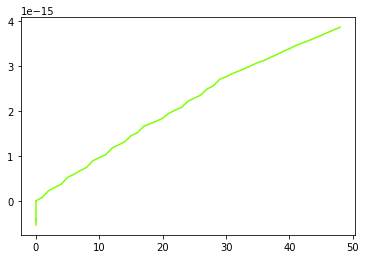

Time to compute frame 49: 0:00:00.865967


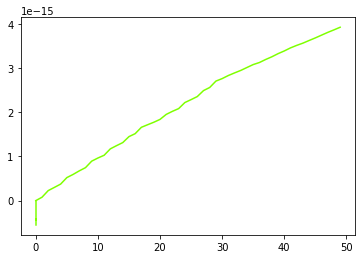

Time to compute frame 50: 0:00:00.855756


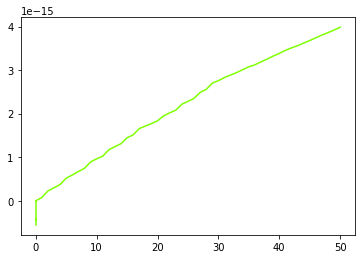

Time to compute frame 51: 0:00:00.834662


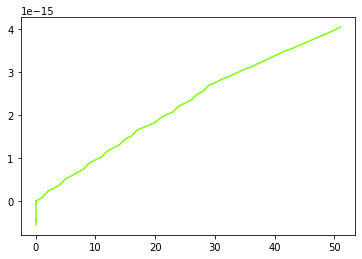

Time to compute frame 52: 0:00:00.801962


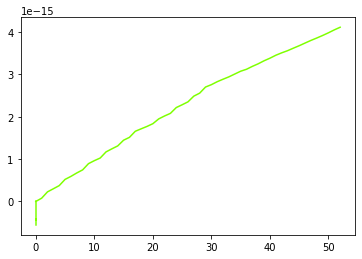

Time to compute frame 53: 0:00:00.846933


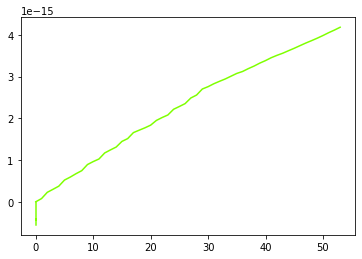

Time to compute frame 54: 0:00:00.867248


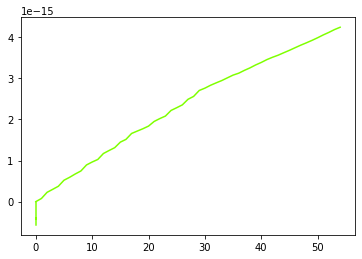

Time to compute frame 55: 0:00:00.839145


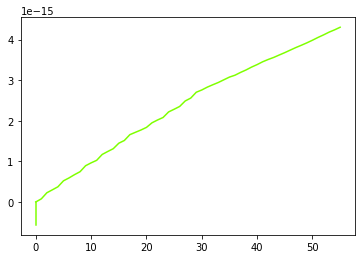

Time to compute frame 56: 0:00:00.892712


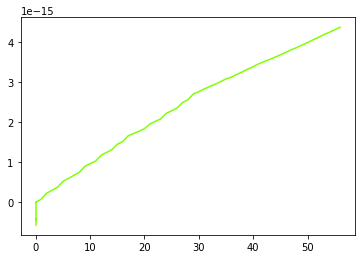

Time to compute frame 57: 0:00:00.873937


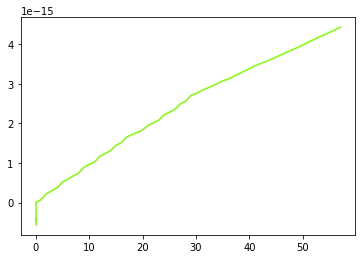

Time to compute frame 58: 0:00:00.920242


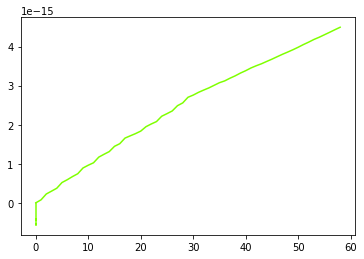

Time to compute frame 59: 0:00:00.908709


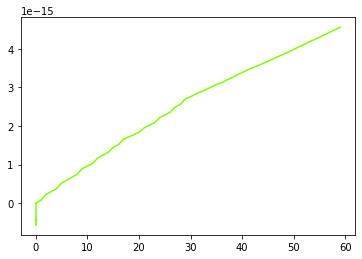

Time to compute frame 60: 0:00:00.916843


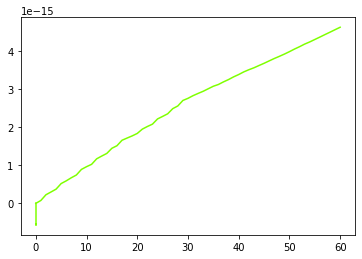

Time to compute frame 61: 0:00:00.915974


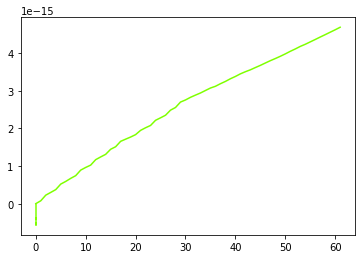

Time to compute frame 62: 0:00:00.910558


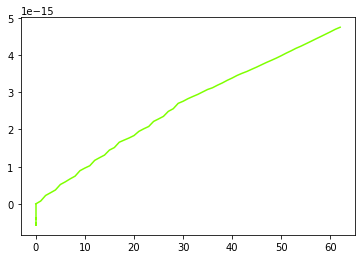

Time to compute frame 63: 0:00:00.891886


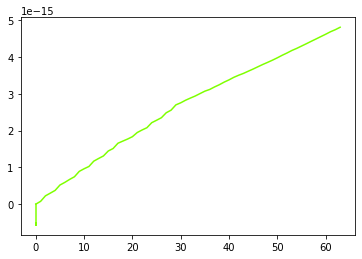

Time to compute frame 64: 0:00:00.890970


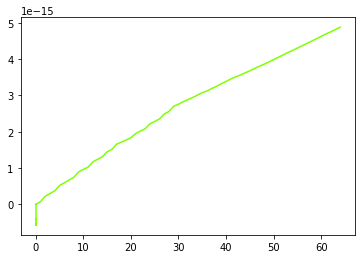

Time to compute frame 65: 0:00:00.954742


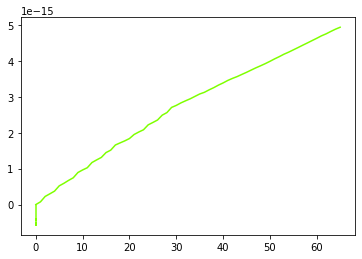

Time to compute frame 66: 0:00:01.079516


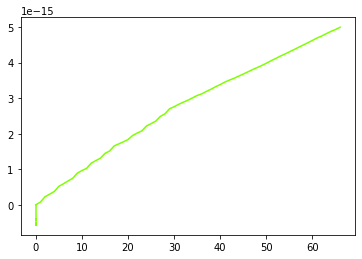

Time to compute frame 67: 0:00:00.867190


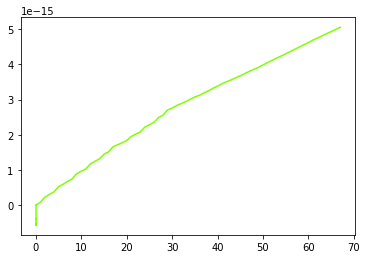

Time to compute frame 68: 0:00:00.878885


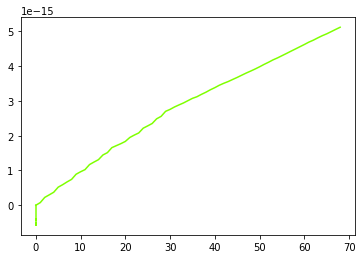

Time to compute frame 69: 0:00:00.881357


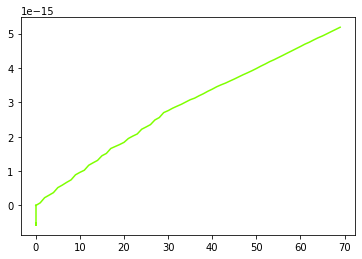

Time to compute frame 70: 0:00:00.884836


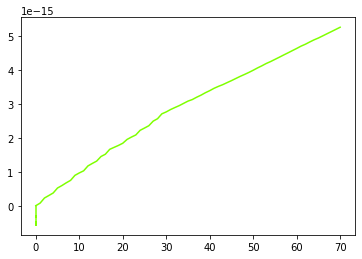

Time to compute frame 71: 0:00:00.863674


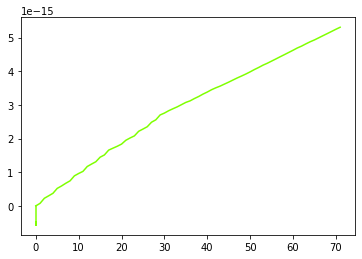

Time to compute frame 72: 0:00:00.882849


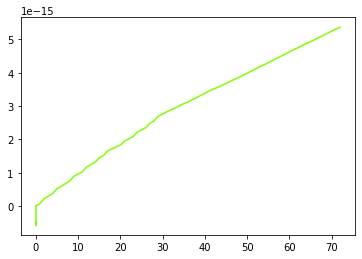

Time to compute frame 73: 0:00:00.868030


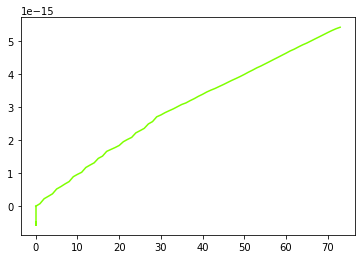

Time to compute frame 74: 0:00:00.909010


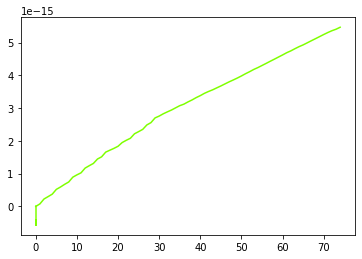

Time to compute frame 75: 0:00:00.868933


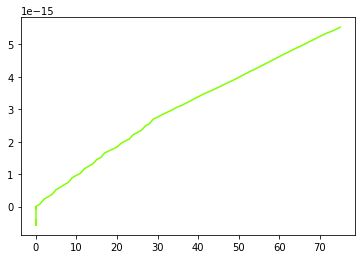

Time to compute frame 76: 0:00:01.005164


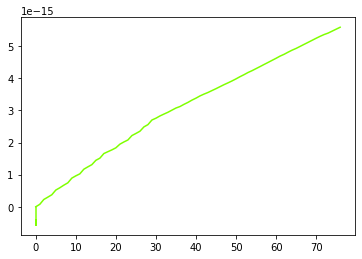

Time to compute frame 77: 0:00:00.854495


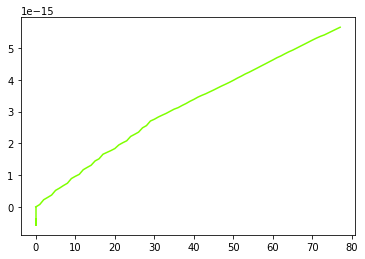

Time to compute frame 78: 0:00:00.862913


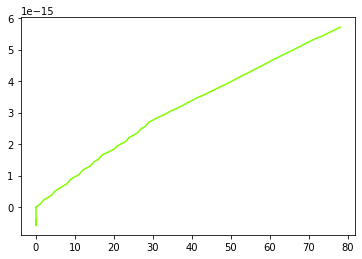

Time to compute frame 79: 0:00:00.854690


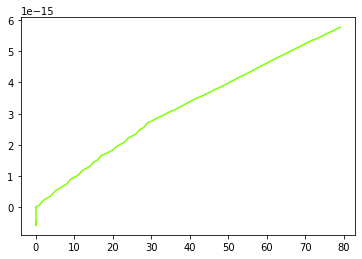

Time to compute frame 80: 0:00:00.867031


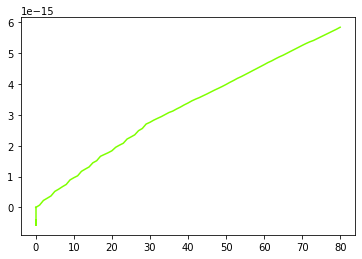

Time to compute frame 81: 0:00:00.850620


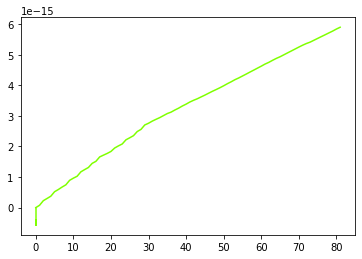

Time to compute frame 82: 0:00:00.853612


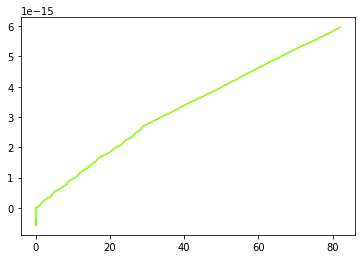

Time to compute frame 83: 0:00:00.866016


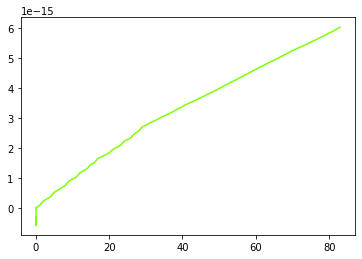

Time to compute frame 84: 0:00:00.856013


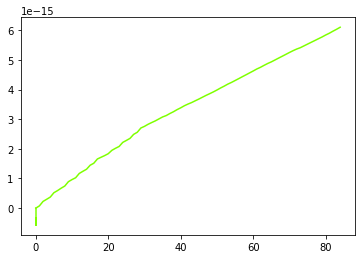

Time to compute frame 85: 0:00:00.875326


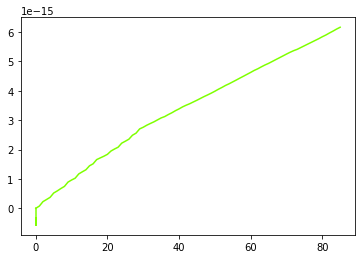

Time to compute frame 86: 0:00:01.041984


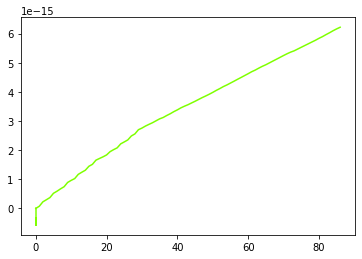

Time to compute frame 87: 0:00:01.017801


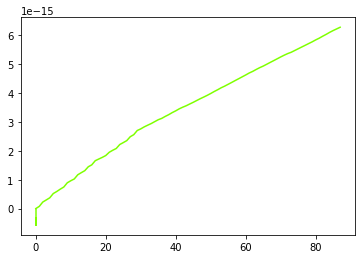

Time to compute frame 88: 0:00:00.983587


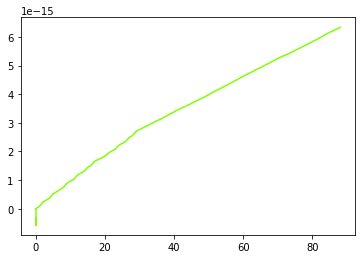

Time to compute frame 89: 0:00:00.886607


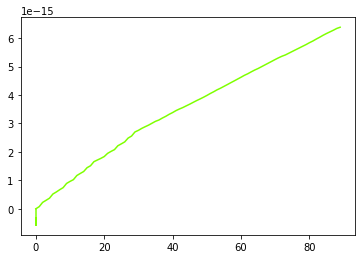

Time to compute frame 90: 0:00:00.871865


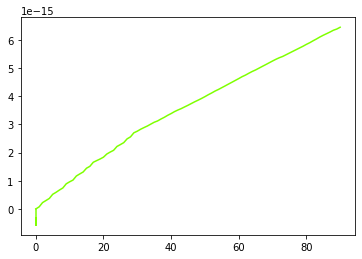

Time to compute frame 91: 0:00:00.861692


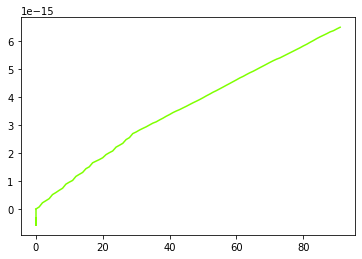

Time to compute frame 92: 0:00:00.857290


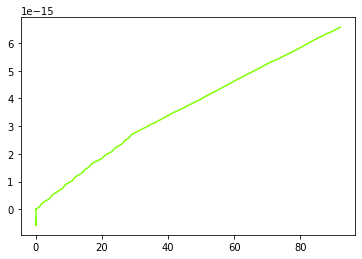

Time to compute frame 93: 0:00:00.820323


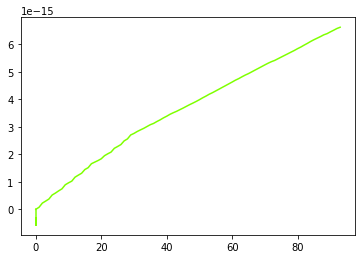

Time to compute frame 94: 0:00:00.848941


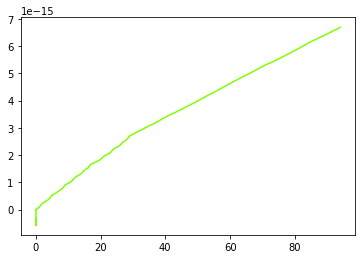

Time to compute frame 95: 0:00:00.856236


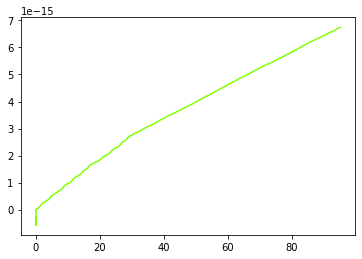

Time to compute frame 96: 0:00:00.856423


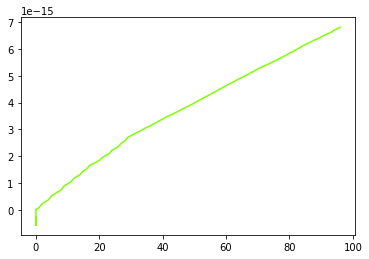

Time to compute frame 97: 0:00:00.878509


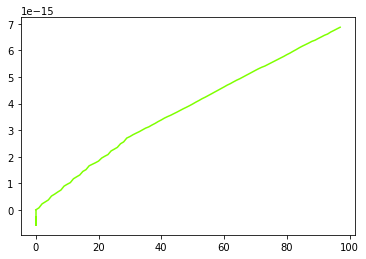

Time to compute frame 98: 0:00:00.869681


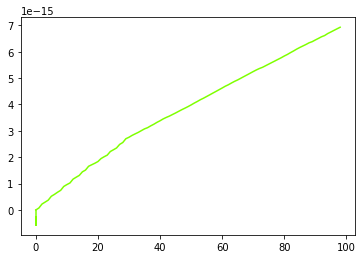

Time to compute frame 99: 0:00:00.851036


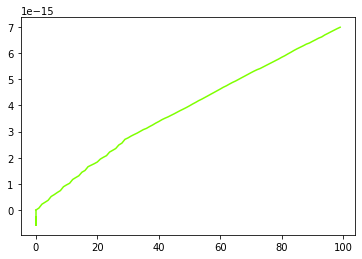

Time to compute frame 100: 0:00:00.967513


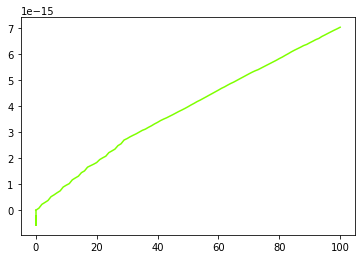

Time to compute frame 101: 0:00:01.210091


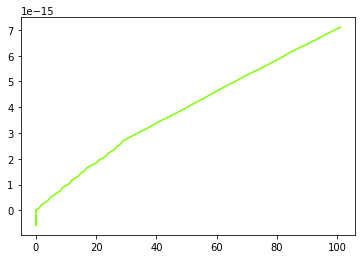

Time to compute frame 102: 0:00:01.091817


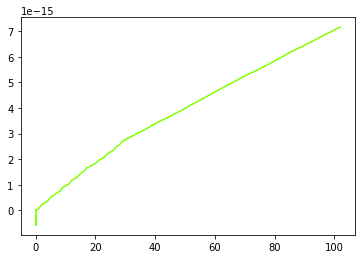

Time to compute frame 103: 0:00:00.873208


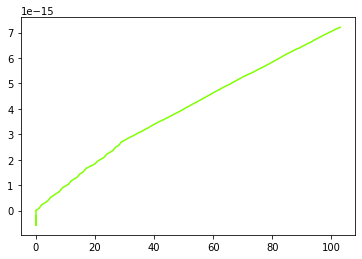

Time to compute frame 104: 0:00:01.212876


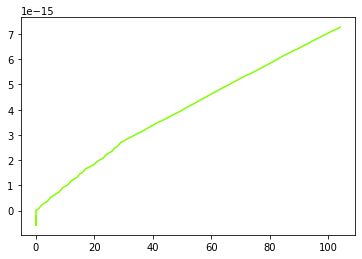

Time to compute frame 105: 0:00:00.915695


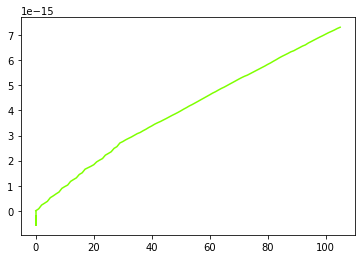

Time to compute frame 106: 0:00:00.873400


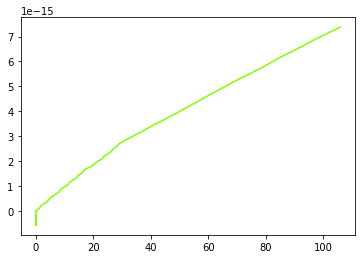

Time to compute frame 107: 0:00:00.893664


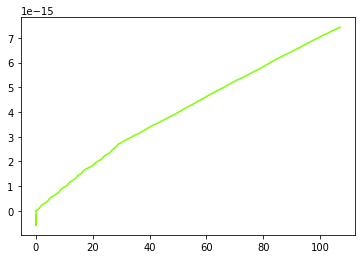

Time to compute frame 108: 0:00:00.922681


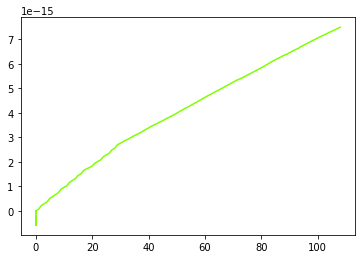

Time to compute frame 109: 0:00:00.899085


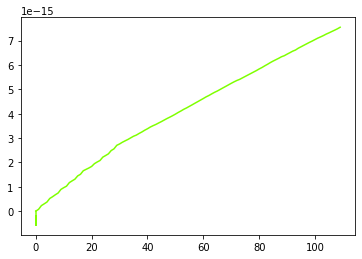

Time to compute frame 110: 0:00:00.910463


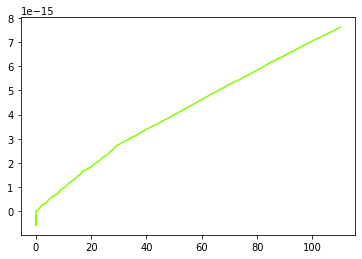

Time to compute frame 111: 0:00:00.964203


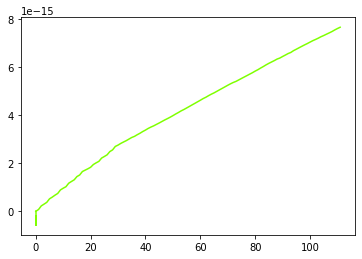

Time to compute frame 112: 0:00:00.915773


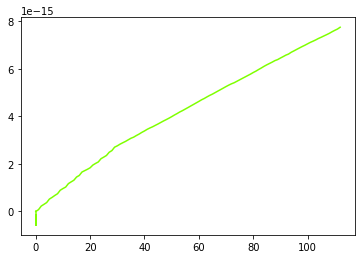

Time to compute frame 113: 0:00:00.911546


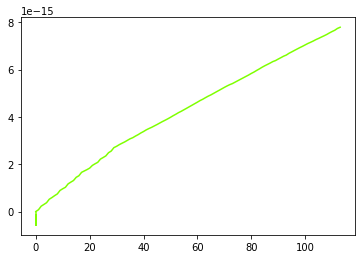

Time to compute frame 114: 0:00:00.881455


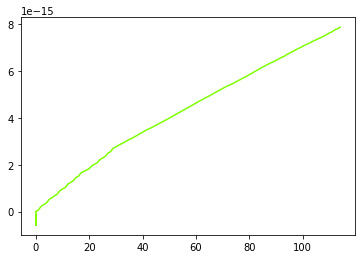

Time to compute frame 115: 0:00:00.882767


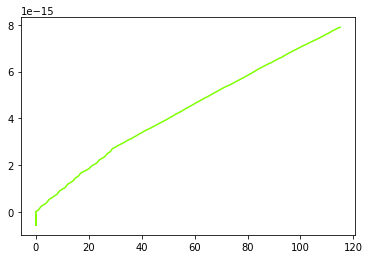

Time to compute frame 116: 0:00:00.903585


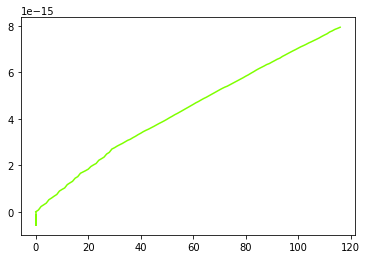

Time to compute frame 117: 0:00:00.899127


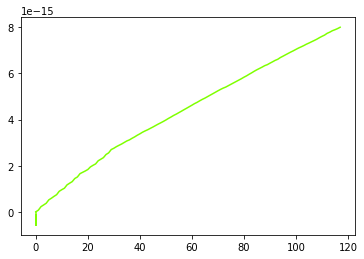

Time to compute frame 118: 0:00:00.902672


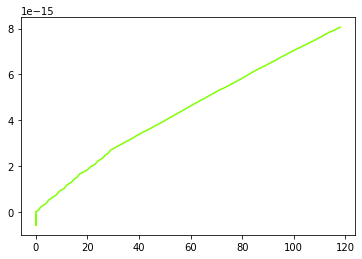

Time to compute frame 119: 0:00:00.898030


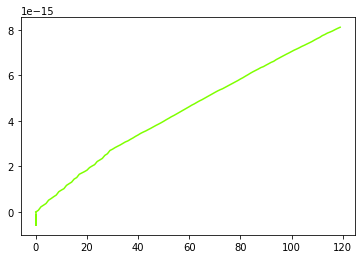

Time to compute frame 120: 0:00:00.910976


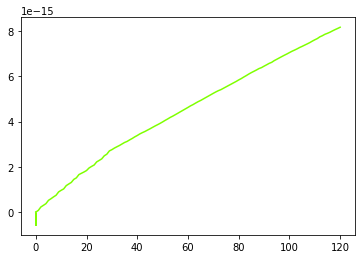

Time to compute frame 121: 0:00:00.882956


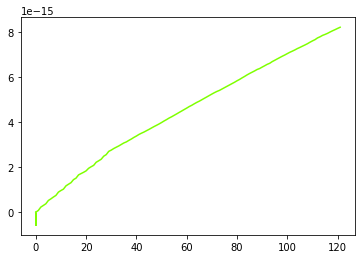

Time to compute frame 122: 0:00:00.899007


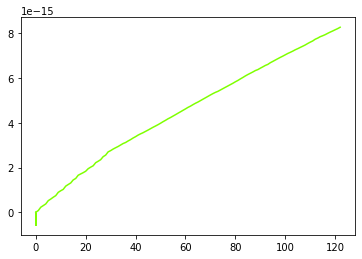

Time to compute frame 123: 0:00:00.881816


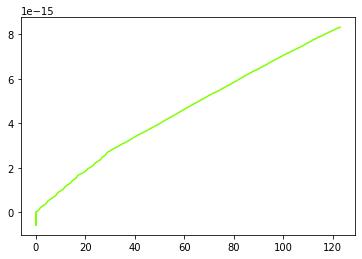

Time to compute frame 124: 0:00:00.904277


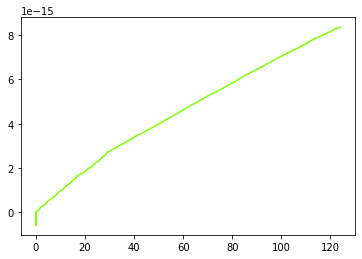

Time to compute frame 125: 0:00:00.907251


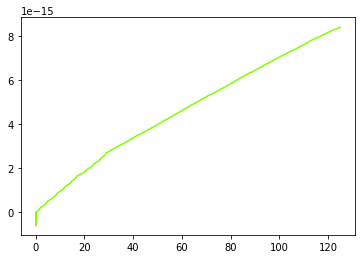

Time to compute frame 126: 0:00:00.880743


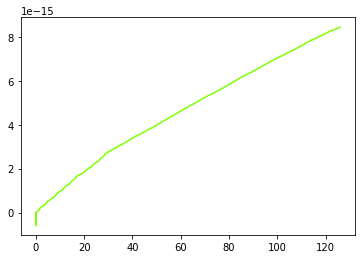

Time to compute frame 127: 0:00:00.888882


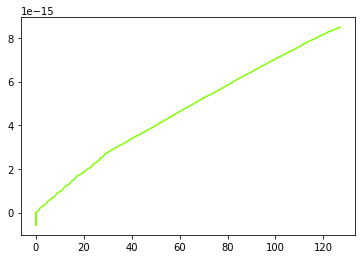

Time to compute frame 128: 0:00:00.917180


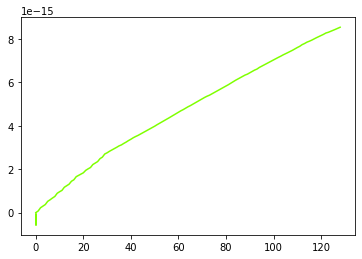

Time to compute frame 129: 0:00:00.880663


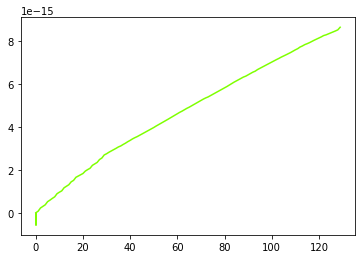

Time to compute frame 130: 0:00:00.883823


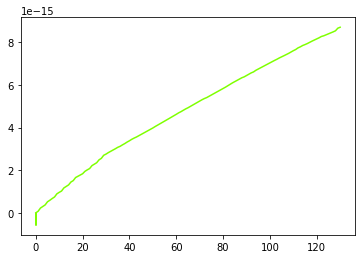

Time to compute frame 131: 0:00:00.894384


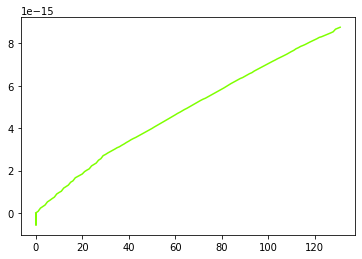

Time to compute frame 132: 0:00:00.894533


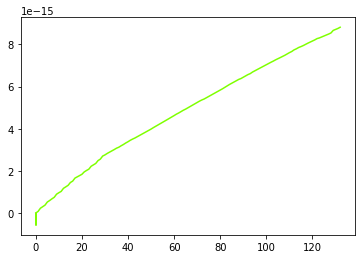

Time to compute frame 133: 0:00:00.860643


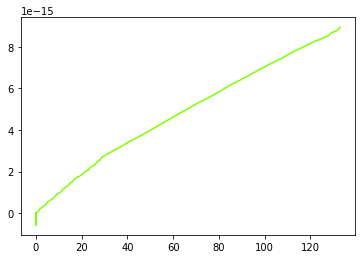

Time to compute frame 134: 0:00:00.872069


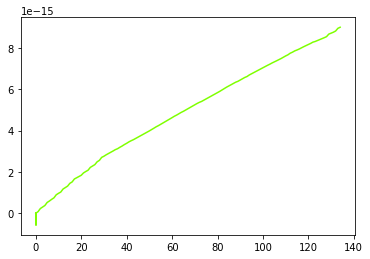

Time to compute frame 135: 0:00:00.882809


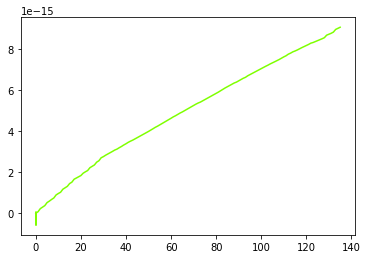

Time to compute frame 136: 0:00:00.861792


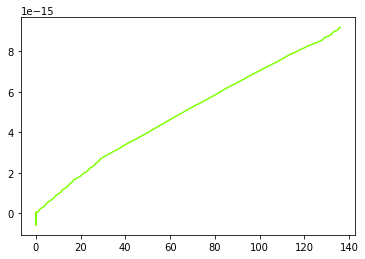

Time to compute frame 137: 0:00:00.883687


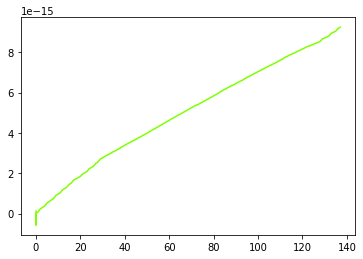

Time to compute frame 138: 0:00:00.874606


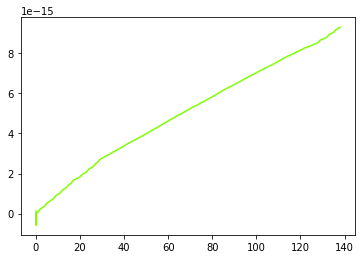

Time to compute frame 139: 0:00:00.864406


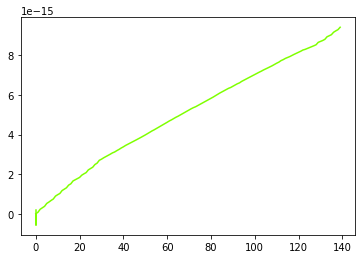

Time to compute frame 140: 0:00:00.882186


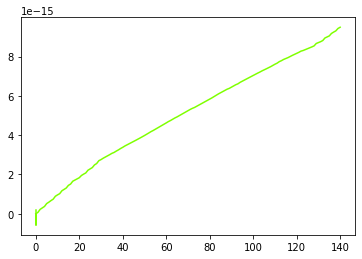

Time to compute frame 141: 0:00:00.888586


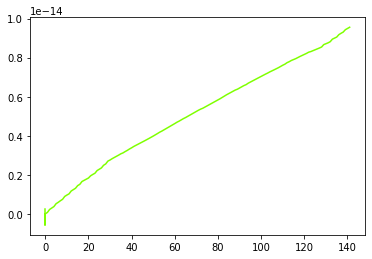

Time to compute frame 142: 0:00:00.847516


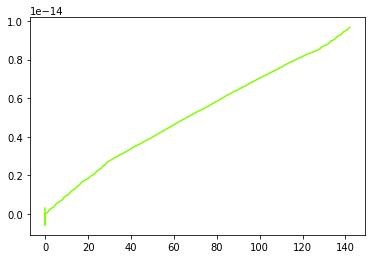

Time to compute frame 143: 0:00:01.042718


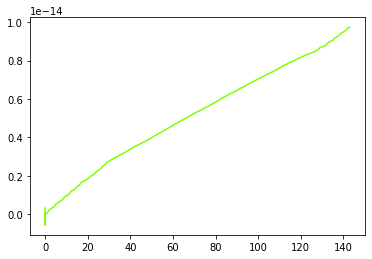

Time to compute frame 144: 0:00:00.856045


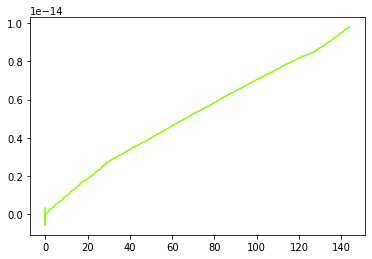

Time to compute frame 145: 0:00:00.875918


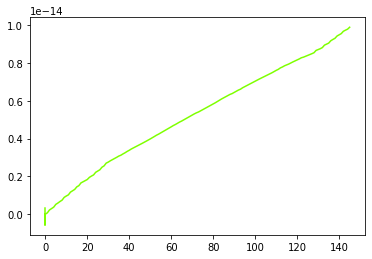

Time to compute frame 146: 0:00:01.051806


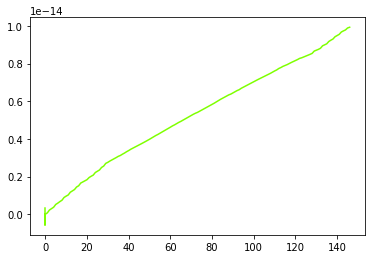

Time to compute frame 147: 0:00:01.029246


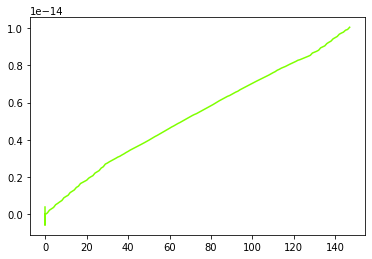

Time to compute frame 148: 0:00:00.956736


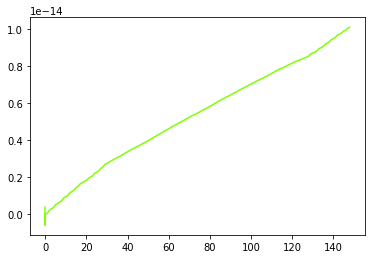

Time to compute frame 149: 0:00:00.957580


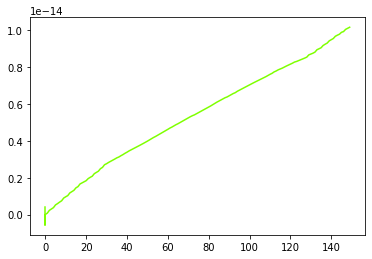

Time to compute frame 150: 0:00:01.040791


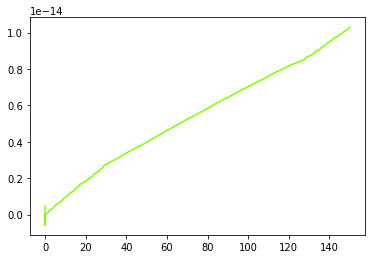

Time to compute frame 151: 0:00:00.913168


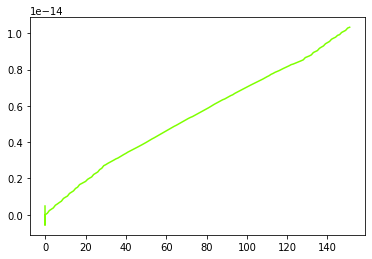

Time to compute frame 152: 0:00:00.926006


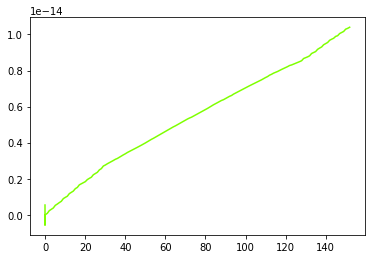

Time to compute frame 153: 0:00:00.996470


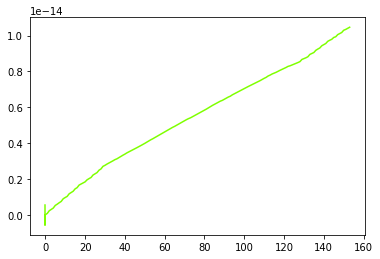

Time to compute frame 154: 0:00:01.068134


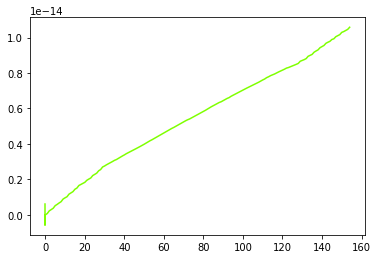

Time to compute frame 155: 0:00:00.981703


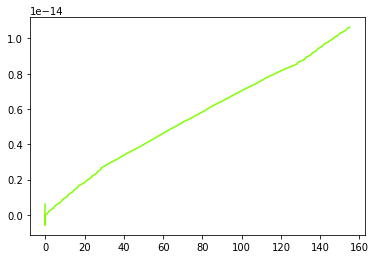

Time to compute frame 156: 0:00:00.935497


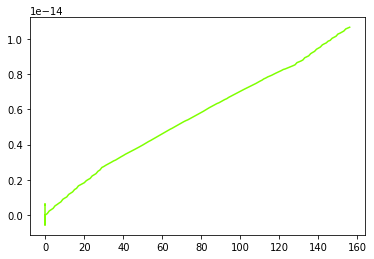

Time to compute frame 157: 0:00:01.025711


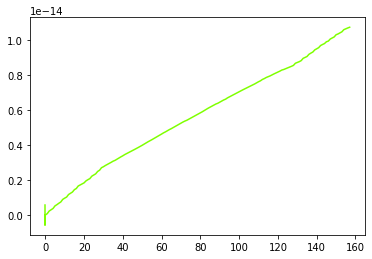

Time to compute frame 158: 0:00:01.009339


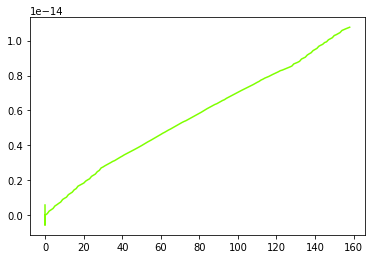

Time to compute frame 159: 0:00:01.042212


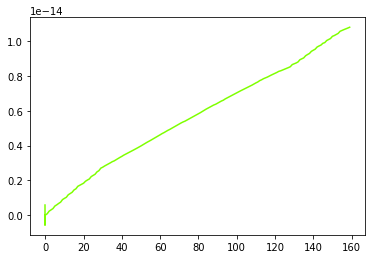

Time to compute frame 160: 0:00:01.092044


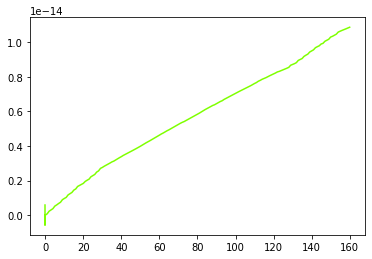

Time to compute frame 161: 0:00:00.969371


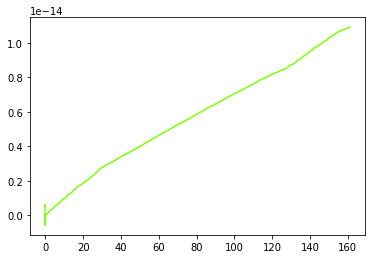

Time to compute frame 162: 0:00:00.865289


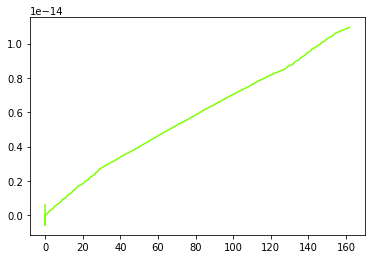

Time to compute frame 163: 0:00:00.864714


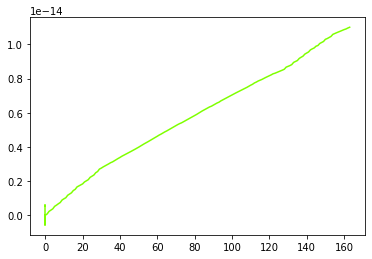

Time to compute frame 164: 0:00:00.840792


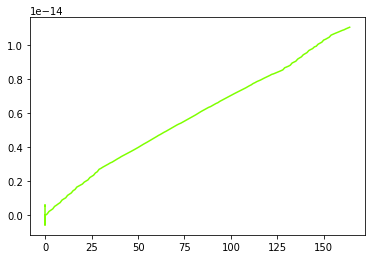

Time to compute frame 165: 0:00:00.866289


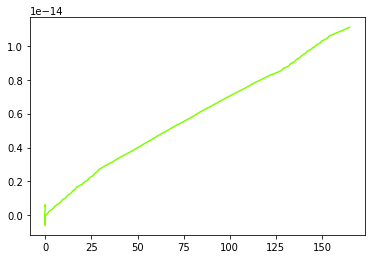

Time to compute frame 166: 0:00:00.847070


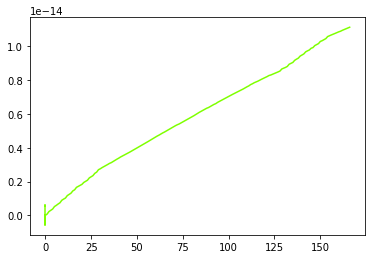

Time to compute frame 167: 0:00:01.013294


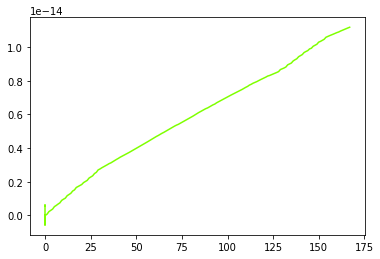

Time to compute frame 168: 0:00:01.058172


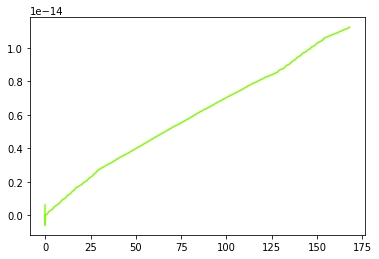

Time to compute frame 169: 0:00:01.034186


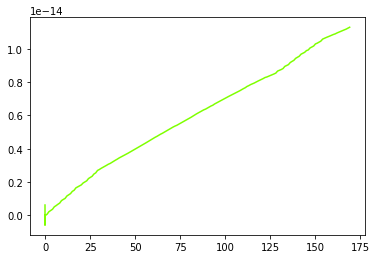

Time to compute frame 170: 0:00:00.956441


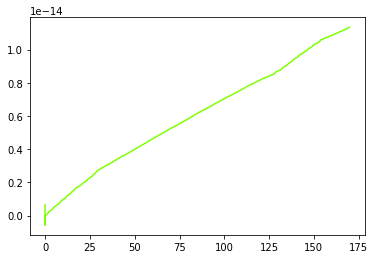

Time to compute frame 171: 0:00:00.880053


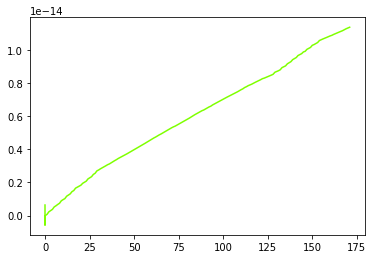

Time to compute frame 172: 0:00:01.040857


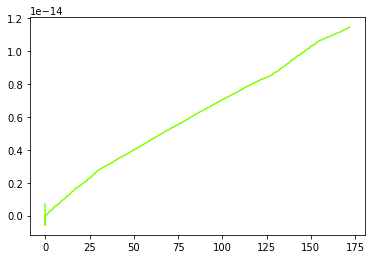

Time to compute frame 173: 0:00:00.862527


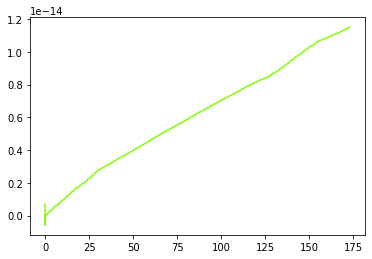

Time to compute frame 174: 0:00:00.921158


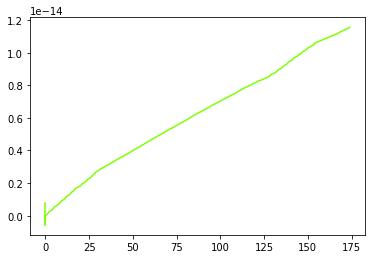

Time to compute frame 175: 0:00:01.060911


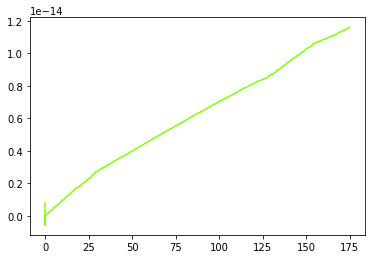

Time to compute frame 176: 0:00:00.915886


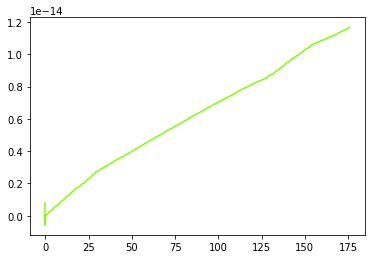

Time to compute frame 177: 0:00:00.871938


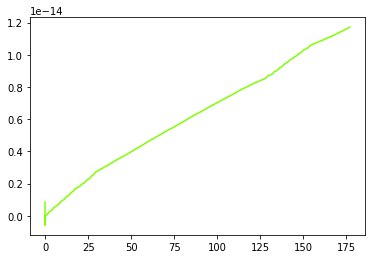

Time to compute frame 178: 0:00:00.881429


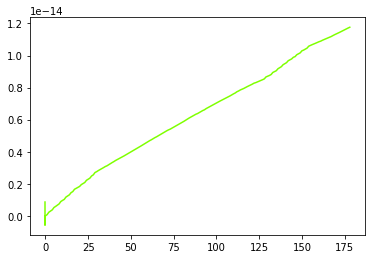

Time to compute frame 179: 0:00:00.876013


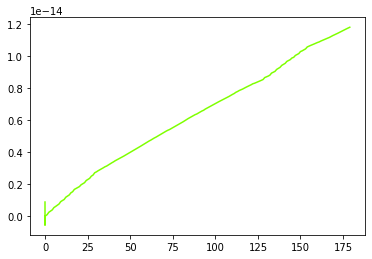

Time to compute frame 180: 0:00:01.185817


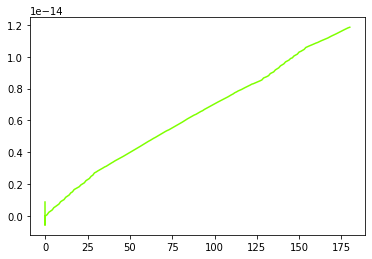

Time to compute frame 181: 0:00:01.115020


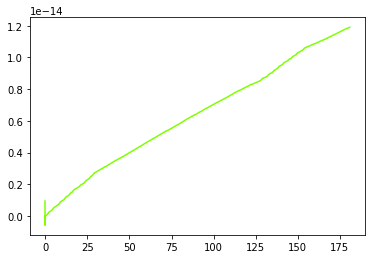

Time to compute frame 182: 0:00:01.087089


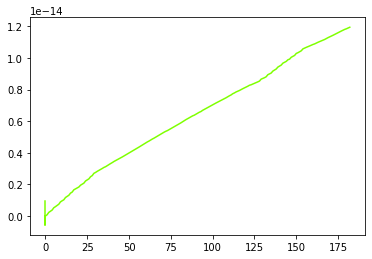

Time to compute frame 183: 0:00:00.999376


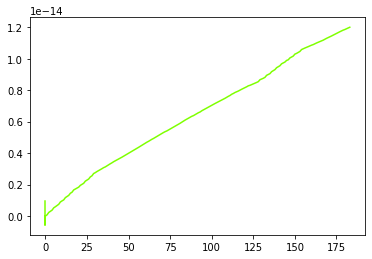

Time to compute frame 184: 0:00:01.037228


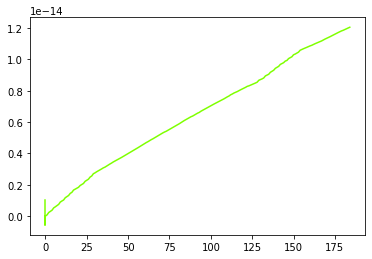

Time to compute frame 185: 0:00:01.058094


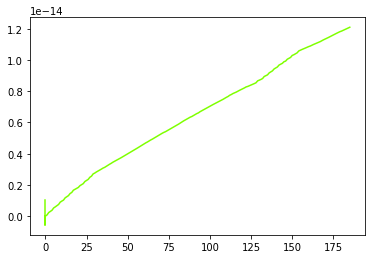

Time to compute frame 186: 0:00:00.999729


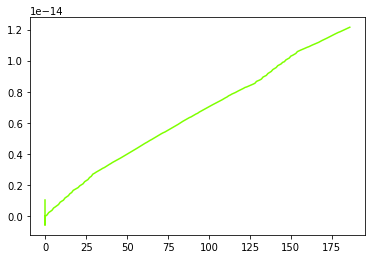

Time to compute frame 187: 0:00:00.916235


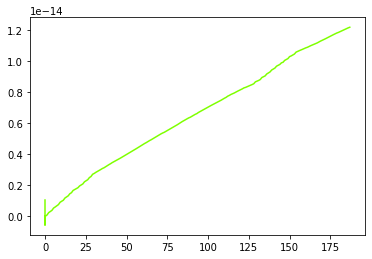

Time to compute frame 188: 0:00:00.917243


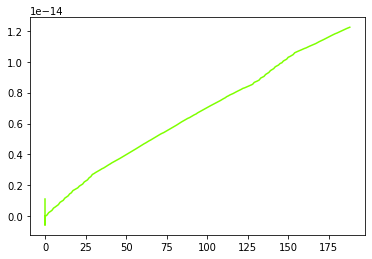

Time to compute frame 189: 0:00:00.926280


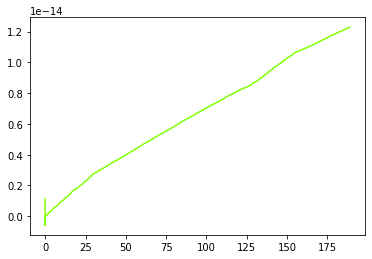

Time to compute frame 190: 0:00:01.076911


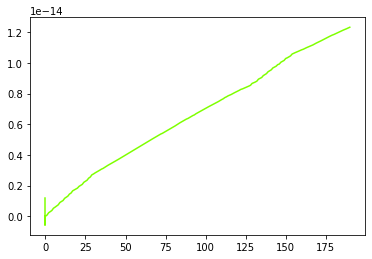

Time to compute frame 191: 0:00:00.946430


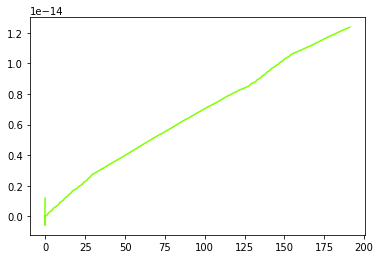

Time to compute frame 192: 0:00:01.002942


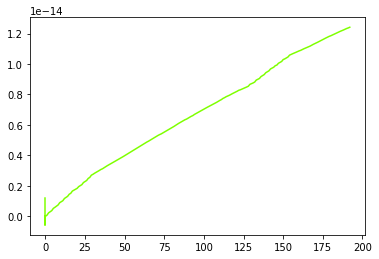

Time to compute frame 193: 0:00:00.937721


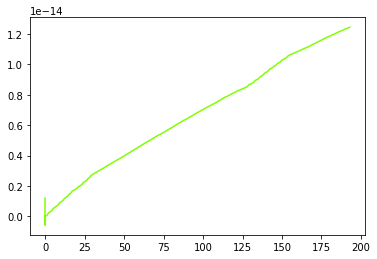

Time to compute frame 194: 0:00:01.014862


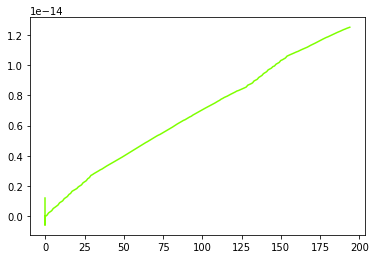

Time to compute frame 195: 0:00:00.942862


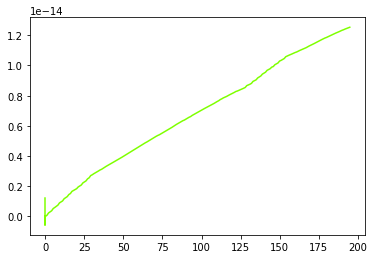

Time to compute frame 196: 0:00:00.949016


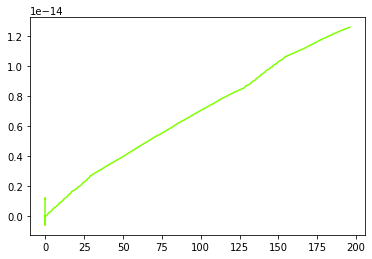

Time to compute frame 197: 0:00:00.964254


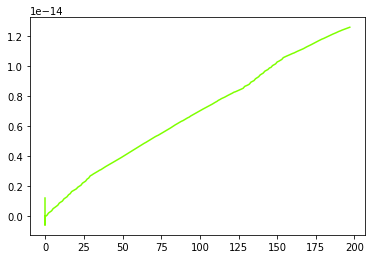

Time to compute frame 198: 0:00:00.966538


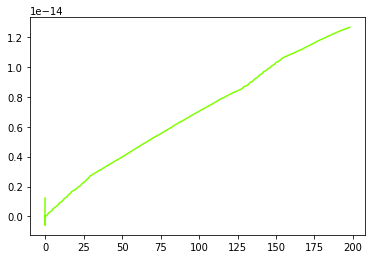

Time to compute frame 199: 0:00:01.151922


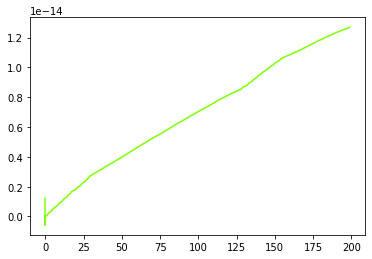

Time to compute frame 200: 0:00:01.126000


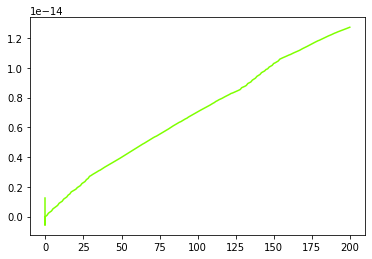

Time to compute frame 201: 0:00:01.142031


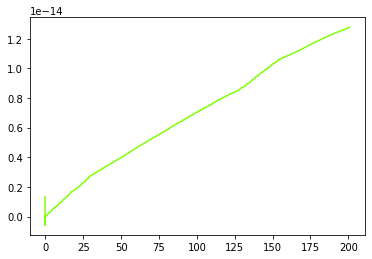

Time to compute frame 202: 0:00:00.946636


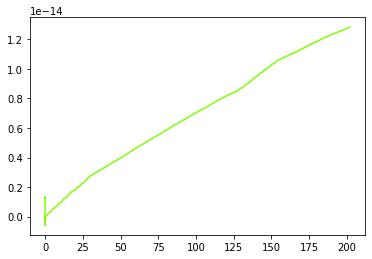

Time to compute frame 203: 0:00:00.981966


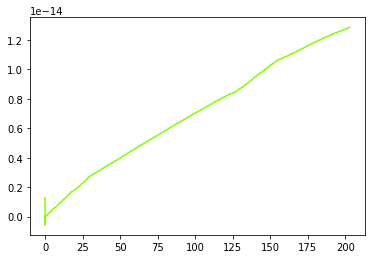

Time to compute frame 204: 0:00:00.895360


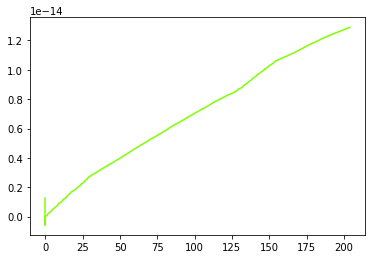

Time to compute frame 205: 0:00:00.903031


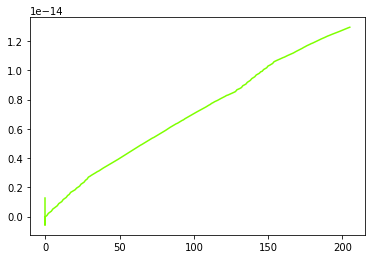

Time to compute frame 206: 0:00:00.925563


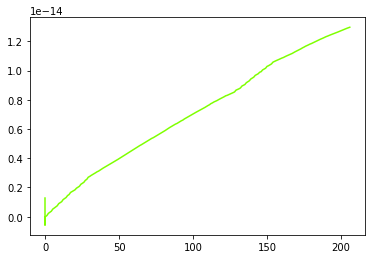

Time to compute frame 207: 0:00:00.968407


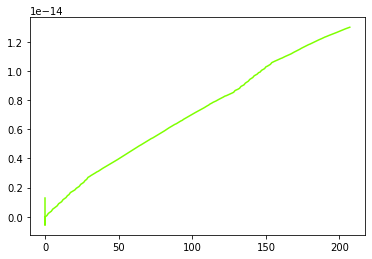

Time to compute frame 208: 0:00:00.913270


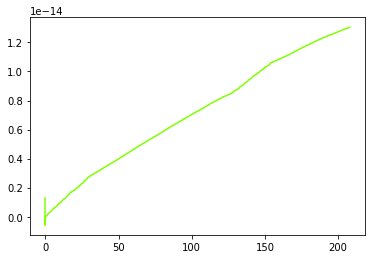

Time to compute frame 209: 0:00:00.919174


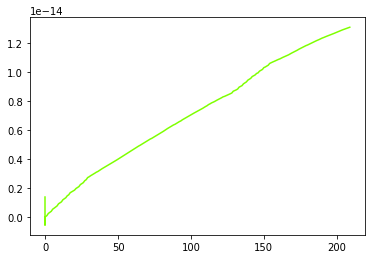

Time to compute frame 210: 0:00:01.156013


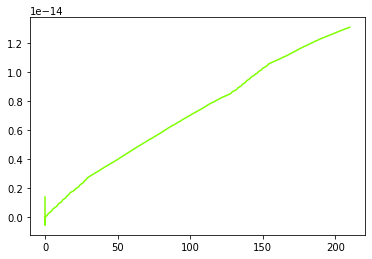

Time to compute frame 211: 0:00:01.101019


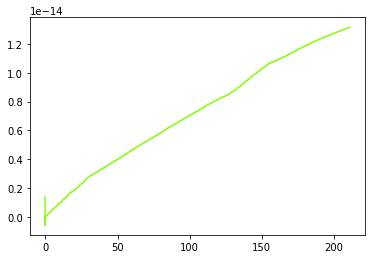

Time to compute frame 212: 0:00:00.927634


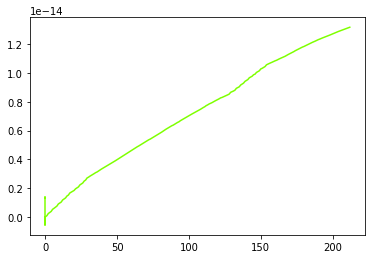

Time to compute frame 213: 0:00:00.905259


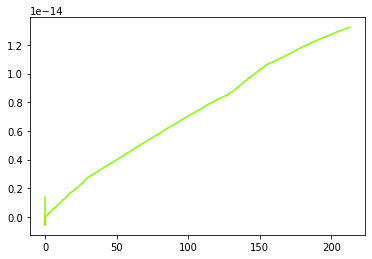

Time to compute frame 214: 0:00:00.891650


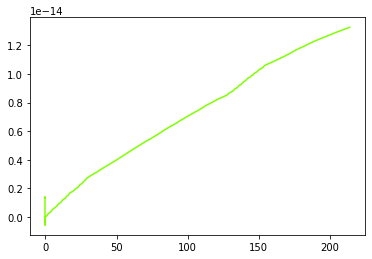

Time to compute frame 215: 0:00:00.869639


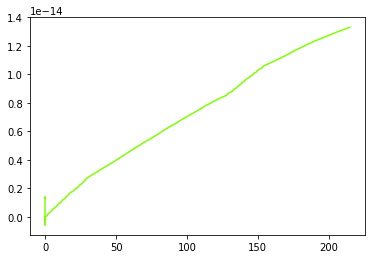

Time to compute frame 216: 0:00:00.874609


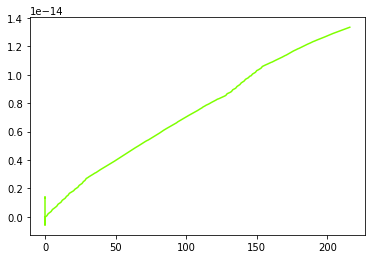

Time to compute frame 217: 0:00:01.074542


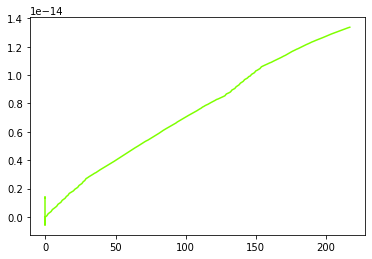

Time to compute frame 218: 0:00:00.884103


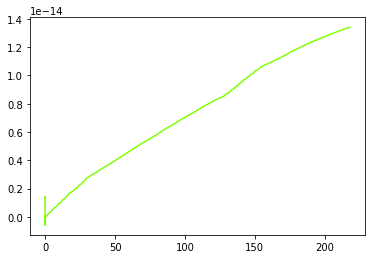

Time to compute frame 219: 0:00:00.868722


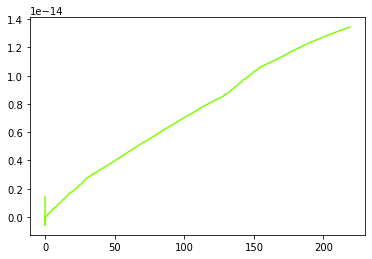

Time to compute frame 220: 0:00:00.867679


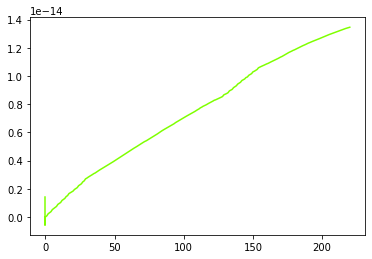

Time to compute frame 221: 0:00:00.871968


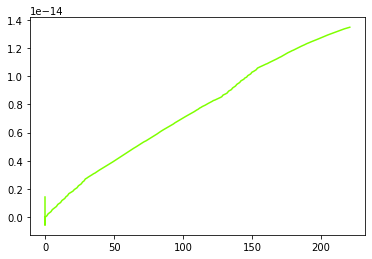

Time to compute frame 222: 0:00:00.880406


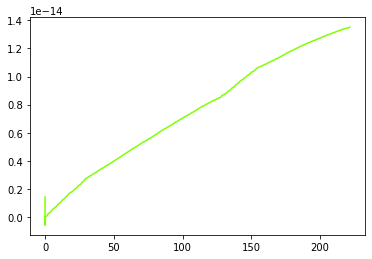

Time to compute frame 223: 0:00:00.880473


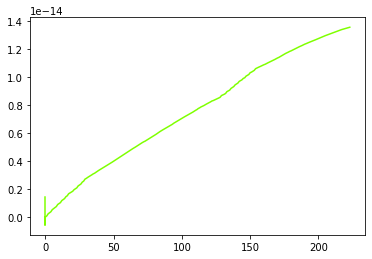

Time to compute frame 224: 0:00:00.876861


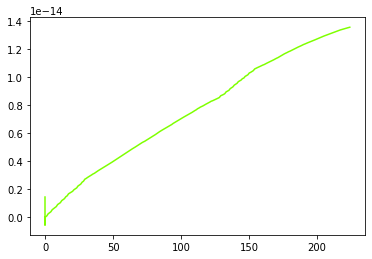

Time to compute frame 225: 0:00:00.895238


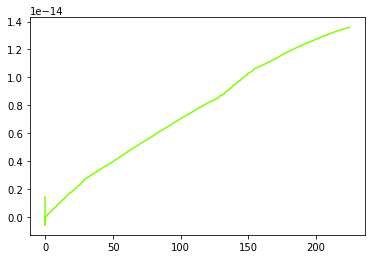

Time to compute frame 226: 0:00:00.865549


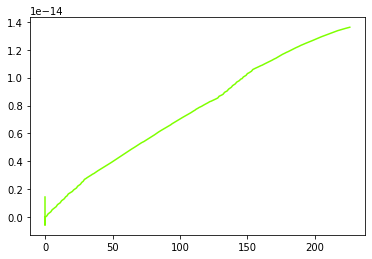

Time to compute frame 227: 0:00:00.869524


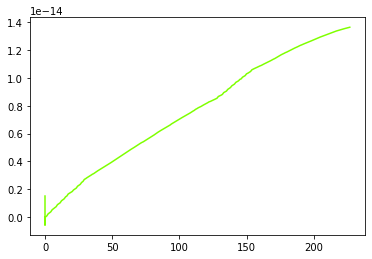

Time to compute frame 228: 0:00:00.886869


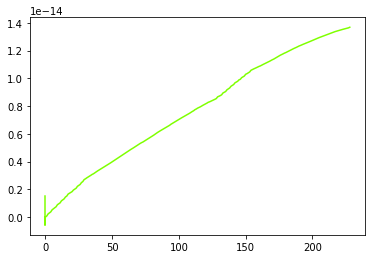

Time to compute frame 229: 0:00:00.868374


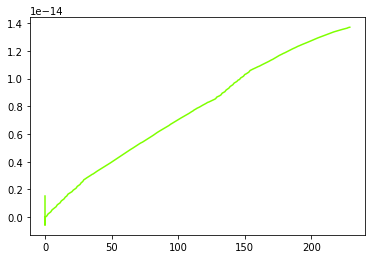

Time to compute frame 230: 0:00:00.897837


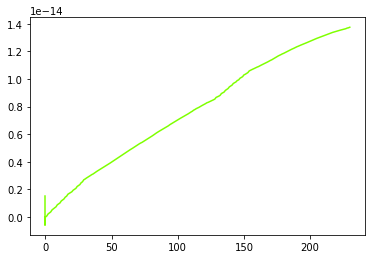

Time to compute frame 231: 0:00:00.895987


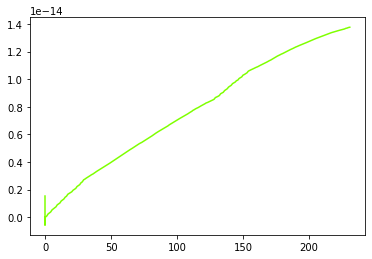

Time to compute frame 232: 0:00:00.887334


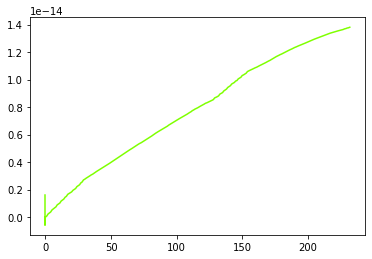

Time to compute frame 233: 0:00:00.889325


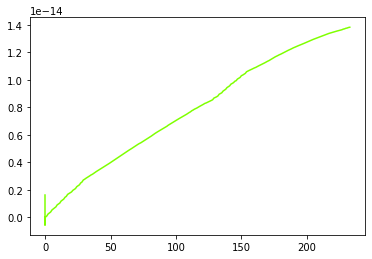

Time to compute frame 234: 0:00:00.886883


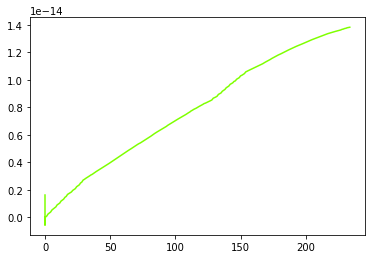

Time to compute frame 235: 0:00:00.877844


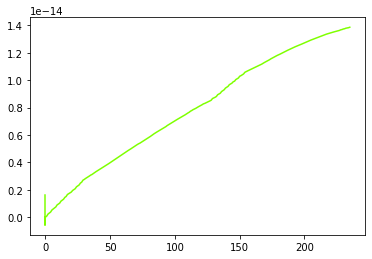

Time to compute frame 236: 0:00:00.877431


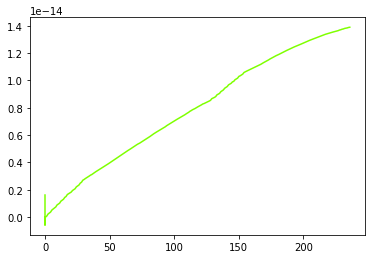

Time to compute frame 237: 0:00:00.874260


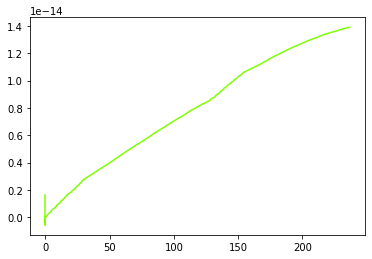

Time to compute frame 238: 0:00:00.872311


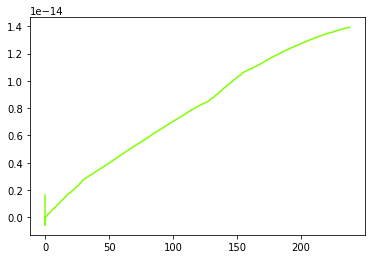

Time to compute frame 239: 0:00:00.897159


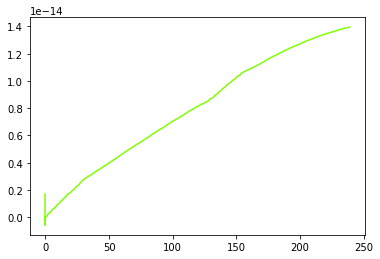

Time to compute frame 240: 0:00:00.871511


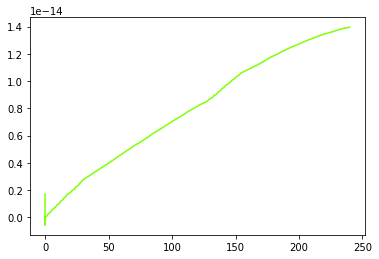

Time to compute frame 241: 0:00:00.863615


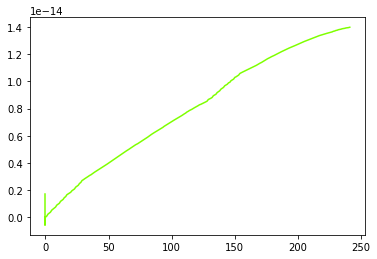

Time to compute frame 242: 0:00:00.867583


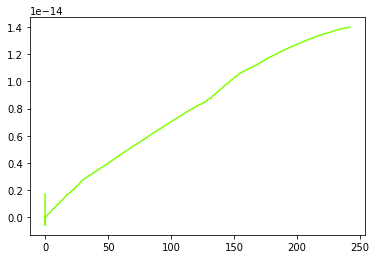

Time to compute frame 243: 0:00:00.895733


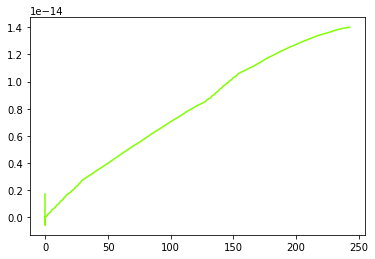

Time to compute frame 244: 0:00:00.860218


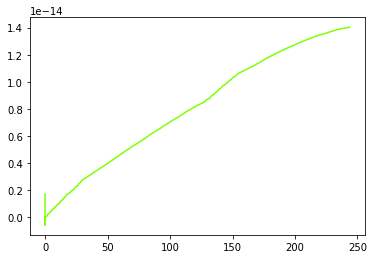

Time to compute frame 245: 0:00:00.877912


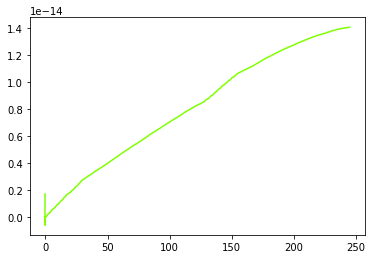

Time to compute frame 246: 0:00:01.015631


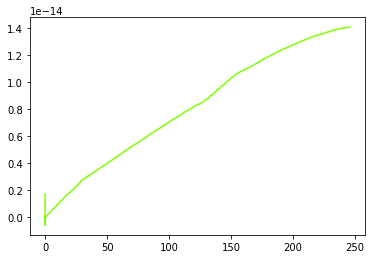

Time to compute frame 247: 0:00:00.909829


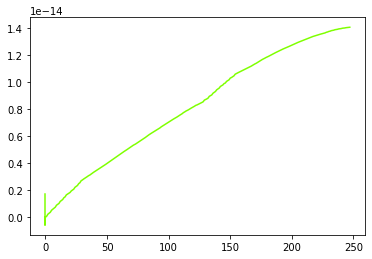

Time to compute frame 248: 0:00:00.990312


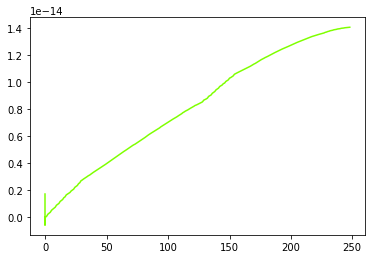

Time to compute frame 249: 0:00:01.121123


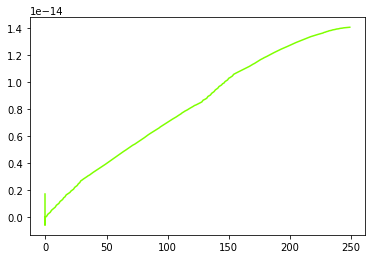

Time to compute frame 250: 0:00:00.924725


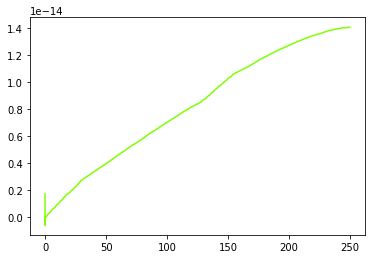

Time to compute frame 251: 0:00:01.019685


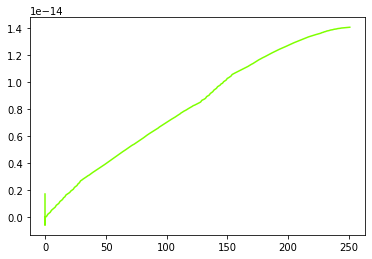

Time to compute frame 252: 0:00:00.989252


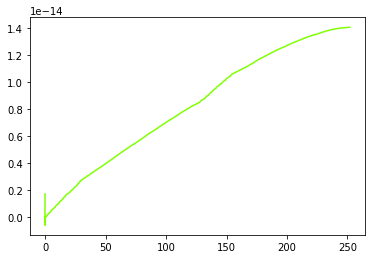

Time to compute frame 253: 0:00:00.936137


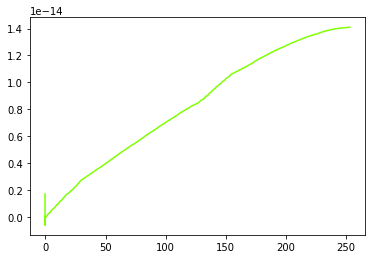

Time to compute frame 254: 0:00:01.056174


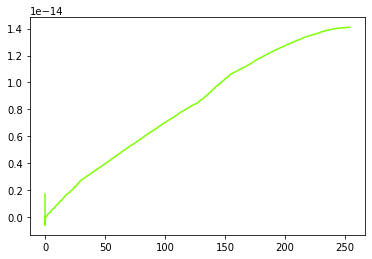

Time to compute frame 255: 0:00:01.331363


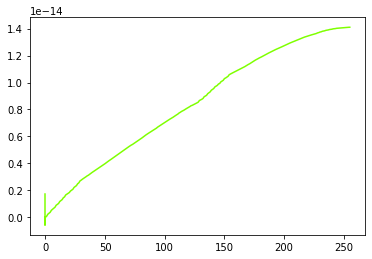

Time to compute frame 256: 0:00:00.999693


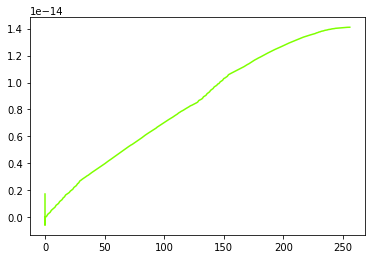

Time to compute frame 257: 0:00:00.922426


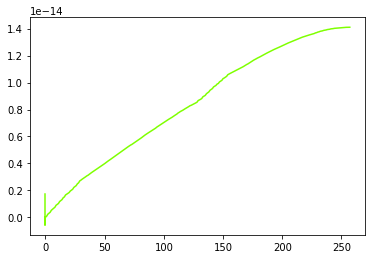

Time to compute frame 258: 0:00:01.065016


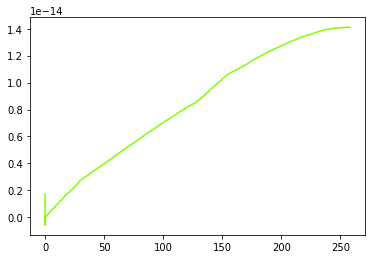

Time to compute frame 259: 0:00:00.923491


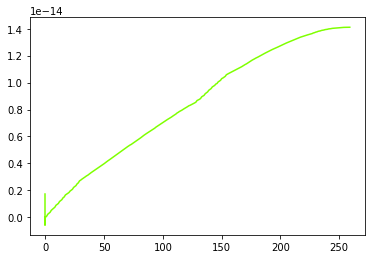

Time to compute frame 260: 0:00:00.922877


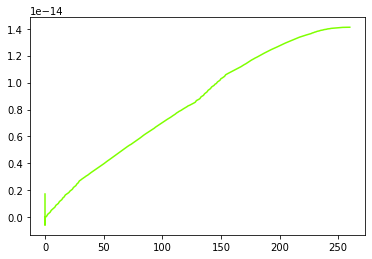

Time to compute frame 261: 0:00:01.393018


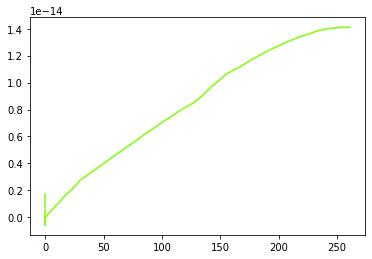

Time to compute frame 262: 0:00:01.341334


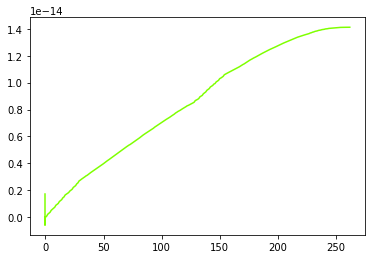

Time to compute frame 263: 0:00:01.295951


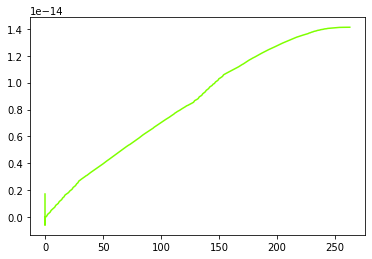

Time to compute frame 264: 0:00:01.219713


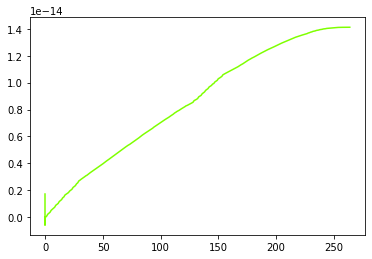

Time to compute frame 265: 0:00:01.152341


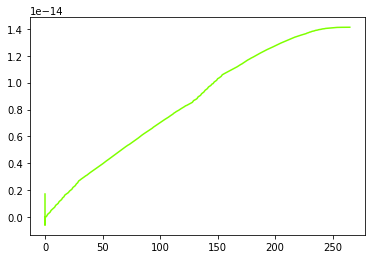

Time to compute frame 266: 0:00:01.255060


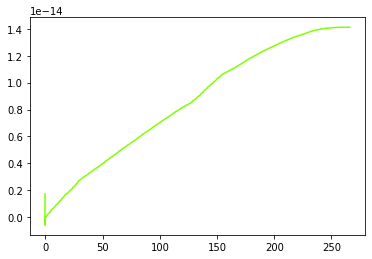

Time to compute frame 267: 0:00:01.057173


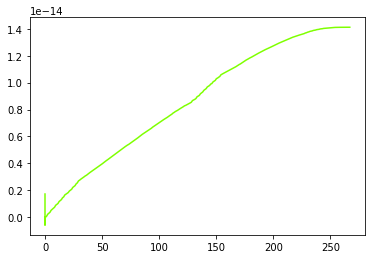

Time to compute frame 268: 0:00:01.000326


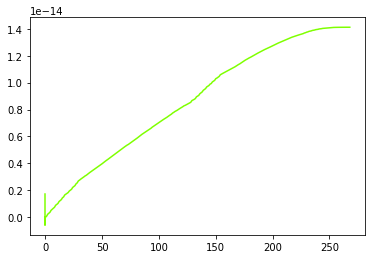

Time to compute frame 269: 0:00:01.084099


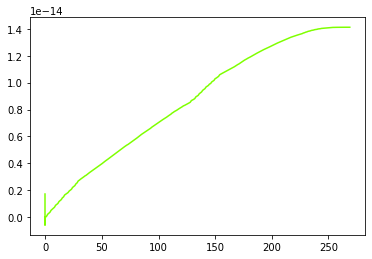

Time to compute frame 270: 0:00:01.101068


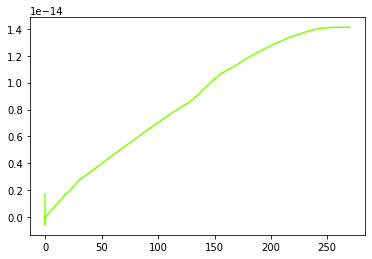

In [80]:
trajectory_test = visual_odometry(handler, 
                                  detector='sift',
                                  matching='BF',
                                  filter_match_distance=0.3,
                                  stereo_matcher='sgbm',
                                  mask=mask,
                                  subset=None,
                                  plot=True
                                 )